# Clusterizacao - Case ImdbMovies

# IMDb TOP 250 Movies
![An image](https://static.amazon.jobs/teams/53/images/IMDb_Header_Page.jpg?1501027252)

**Este projeto consiste em treinar um sistema de recomendação de filmes utilizando as informações referentes aos top 250 filmes melhor avaliados pelo público na plataforma IMDb.**
*   A extração dos dados será feita por técnicas de web scraping (crawler).
*   O objetivo principal será agrupar os 250 filmes em "n" clusters classificados a partir das suas sinopses, aplicando técnicas de processamento de texto e algoritmos de clusterização.
*   Ao final, teremos um sistemas de recomendação baseado na similaridade das sinopses, e não apenas dos generos.

**Exemplo de aplicação prática: usuários receberão recomendações de filmes que estejam no mesmo cluster de sinopses de outros filmes que ele já tenha curtido.**

# Import das bibliotecas

In [1]:
import pandas as pd
import numpy as np
import requests
from pprint import pprint
from bs4 import BeautifulSoup
import re
import json
from urllib.request import Request, urlopen
from lxml import html
import time
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
import pandas as pd
import time

# Web Scraping / Crawler

In [2]:
# Configurar o Selenium para rodar no modo headless (sem interface gráfica)
chrome_options = Options()
chrome_options.add_argument("--headless")
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--disable-dev-shm-usage")

# Definir o User-Agent para imitar um navegador real
chrome_options.add_argument(
    "user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"
)
chrome_options.add_argument("--lang=en-US")


# Inicializar o navegador (certifique-se de ter o ChromeDriver baixado)
driver = webdriver.Chrome(options=chrome_options)

# Acessar a página do IMDb
url = 'https://www.imdb.com/chart/top/?ref_=nv_mv_250'
driver.get(url)

# Adicionar uma espera para garantir que a página carregue completamente
time.sleep(10)

# Obter o HTML renderizado pelo Selenium
html = driver.page_source

In [3]:
bs = BeautifulSoup(html)
pprint(bs)

<html class="scriptsOn" lang="en-US" xmlns:fb="http://www.facebook.com/2008/fbml" xmlns:og="http://opengraphprotocol.org/schema/"><head><script async="" src="https://sb.scorecardresearch.com/beacon.js"></script><script async="" crossorigin="anonymous" src="https://images-na.ssl-images-amazon.com/images/I/31bJewCvY-L.js"></script><meta charset="utf-8"/><meta content="width=device-width" name="viewport"/><script>if(typeof uet === 'function'){ uet('bb', 'LoadTitle', {wb: 1}); }</script><title>IMDb Top 250 Movies</title><meta content="As rated by regular IMDb voters." data-id="main" name="description"/><meta content="IMDb" property="og:site_name"/><meta content="IMDb Top 250 Movies" property="og:title"/><meta content="As rated by regular IMDb voters." property="og:description"/><meta content="website" property="og:type"/><meta content="https://m.media-amazon.com/images/G/01/imdb/images/social/imdb_logo.png" property="og:image"/><meta content="1000" property="og:image:height"/><meta content

## Title EN

In [4]:
titles = bs.find_all('h3', attrs={'class':'ipc-title__text'})
# Filtrar apenas os títulos que são filmes
for t in titles:
    title_text = t.get_text()
    
    # Verificar se o título começa com um número (os filmes têm um número antes do nome)
    if title_text[0].isdigit():
        print(title_text)

1. The Shawshank Redemption
2. The Godfather
3. The Dark Knight
4. The Godfather Part II
5. 12 Angry Men
6. Schindler's List
7. The Lord of the Rings: The Return of the King
8. Pulp Fiction
9. The Lord of the Rings: The Fellowship of the Ring
10. The Good, the Bad and the Ugly
11. Forrest Gump
12. The Lord of the Rings: The Two Towers
13. Fight Club
14. Inception
15. Star Wars: Episode V - The Empire Strikes Back
16. The Matrix
17. Goodfellas
18. One Flew Over the Cuckoo's Nest
19. Interstellar
20. Se7en
21. It's a Wonderful Life
22. Seven Samurai
23. The Silence of the Lambs
24. Saving Private Ryan
25. City of God
26. Life Is Beautiful
27. The Green Mile
28. Terminator 2: Judgment Day
29. Star Wars: Episode IV - A New Hope
30. Back to the Future
31. Spirited Away
32. The Pianist
33. Parasite
34. Psycho
35. Gladiator
36. The Lion King
37. Spider-Man: Across the Spider-Verse
38. The Departed
39. Whiplash
40. American History X
41. Léon: The Professional
42. Grave of the Fireflies
43. Th

In [5]:
list_title_en = []
for t in titles:
    title_text = t.get_text()
    if title_text[0].isdigit():
      tit = (title_text).split('.')[-1].strip()
      list_title_en.append(tit)
print(len(list_title_en))
list_title_en

250


['The Shawshank Redemption',
 'The Godfather',
 'The Dark Knight',
 'The Godfather Part II',
 '12 Angry Men',
 "Schindler's List",
 'The Lord of the Rings: The Return of the King',
 'Pulp Fiction',
 'The Lord of the Rings: The Fellowship of the Ring',
 'The Good, the Bad and the Ugly',
 'Forrest Gump',
 'The Lord of the Rings: The Two Towers',
 'Fight Club',
 'Inception',
 'Star Wars: Episode V - The Empire Strikes Back',
 'The Matrix',
 'Goodfellas',
 "One Flew Over the Cuckoo's Nest",
 'Interstellar',
 'Se7en',
 "It's a Wonderful Life",
 'Seven Samurai',
 'The Silence of the Lambs',
 'Saving Private Ryan',
 'City of God',
 'Life Is Beautiful',
 'The Green Mile',
 'Terminator 2: Judgment Day',
 'Star Wars: Episode IV - A New Hope',
 'Back to the Future',
 'Spirited Away',
 'The Pianist',
 'Parasite',
 'Psycho',
 'Gladiator',
 'The Lion King',
 'Spider-Man: Across the Spider-Verse',
 'The Departed',
 'Whiplash',
 'American History X',
 'Léon: The Professional',
 'Grave of the Fireflies

## Year

In [6]:
list_years = []
# years = bs.find_all('div', attrs={'class':'sc-14dd939d-5 cPiUKY cli-title-metadata'})
years = bs.find_all('div', attrs={'class':'sc-b189961a-7 btCcOY cli-title-metadata'})

for y in years:
  year = y.find('div', attrs={'class':'sc-b189961a-7 btCcOY cli-title-metadata'})
for year in years:
    # print(year.text)
  list_years.append(year.text[:4])
display(len(list_years))
list_years

250

['1994',
 '1972',
 '2008',
 '1974',
 '1957',
 '1993',
 '2003',
 '1994',
 '2001',
 '1966',
 '1994',
 '2002',
 '1999',
 '2010',
 '1980',
 '1999',
 '1990',
 '1975',
 '2014',
 '1995',
 '1946',
 '1954',
 '1991',
 '1998',
 '2002',
 '1997',
 '1999',
 '1991',
 '1977',
 '1985',
 '2001',
 '2002',
 '2019',
 '1960',
 '2000',
 '1994',
 '2023',
 '2006',
 '2014',
 '1998',
 '1994',
 '1988',
 '2006',
 '1962',
 '2024',
 '1995',
 '1942',
 '2011',
 '1988',
 '1936',
 '1979',
 '1954',
 '1968',
 '1931',
 '2012',
 '1979',
 '2000',
 '2008',
 '1981',
 '2023',
 '2006',
 '1950',
 '2018',
 '1957',
 '2018',
 '1957',
 '1980',
 '1940',
 '1986',
 '2009',
 '2012',
 '2017',
 '1984',
 '1995',
 '1964',
 '2003',
 '1999',
 '2019',
 '1981',
 '1995',
 '1997',
 '1997',
 '2019',
 '2016',
 '1963',
 '2009',
 '1984',
 '1952',
 '2018',
 '1985',
 '2000',
 '2010',
 '1983',
 '2004',
 '2012',
 '1968',
 '1952',
 '1992',
 '1962',
 '1960',
 '2010',
 '1959',
 '2023',
 '1983',
 '1941',
 '1944',
 '1931',
 '1958',
 '1987',
 '1995',
 '2001',
 

## Rating

In [7]:
list_rating = []

# Step 3: Locate the relevant element
rating_span = bs.find_all('span', class_='ipc-rating-star--rating')
for x in rating_span:
  list_rating.append(x.text)
display(len(list_rating))
list_rating

250

['9.3',
 '9.2',
 '9.0',
 '9.0',
 '9.0',
 '9.0',
 '9.0',
 '8.9',
 '8.9',
 '8.8',
 '8.8',
 '8.8',
 '8.8',
 '8.8',
 '8.7',
 '8.7',
 '8.7',
 '8.7',
 '8.7',
 '8.6',
 '8.6',
 '8.6',
 '8.6',
 '8.6',
 '8.6',
 '8.6',
 '8.6',
 '8.6',
 '8.6',
 '8.5',
 '8.6',
 '8.5',
 '8.5',
 '8.5',
 '8.5',
 '8.5',
 '8.6',
 '8.5',
 '8.5',
 '8.5',
 '8.5',
 '8.5',
 '8.5',
 '8.6',
 '8.5',
 '8.5',
 '8.5',
 '8.5',
 '8.5',
 '8.5',
 '8.5',
 '8.5',
 '8.5',
 '8.5',
 '8.5',
 '8.4',
 '8.4',
 '8.4',
 '8.4',
 '8.9',
 '8.4',
 '8.4',
 '8.4',
 '8.4',
 '8.4',
 '8.4',
 '8.4',
 '8.4',
 '8.4',
 '8.4',
 '8.4',
 '8.4',
 '8.4',
 '8.3',
 '8.3',
 '8.3',
 '8.3',
 '8.4',
 '8.4',
 '8.3',
 '8.3',
 '8.3',
 '8.4',
 '8.4',
 '8.4',
 '8.4',
 '8.3',
 '8.3',
 '8.4',
 '8.4',
 '8.3',
 '8.3',
 '8.3',
 '8.3',
 '8.3',
 '8.3',
 '8.3',
 '8.3',
 '8.3',
 '8.3',
 '8.3',
 '8.3',
 '8.3',
 '8.3',
 '8.3',
 '8.3',
 '8.3',
 '8.3',
 '8.2',
 '8.3',
 '8.3',
 '8.3',
 '8.2',
 '8.3',
 '8.3',
 '8.3',
 '8.2',
 '8.2',
 '8.3',
 '8.3',
 '8.2',
 '8.2',
 '8.2',
 '8.3',
 '8.3',


## Genre, Title PT & Year

In [8]:
list_links = []
# Encontrar todos os elementos <a> com o atributo href
for a in bs.find_all('a', href=True):
    href = a['href']
    
    # Verificar se o link contém '/title/' e tem o formato específico 'ref_=chttp_t_'
    if '/title/' in href and 'ref_=chttp_t_' in href:
        # Construir o link completo
        full_link = 'https://www.imdb.com' + href
        
        # Adicionar à lista, se ainda não estiver presente
        if full_link not in list_links:
            list_links.append(full_link)

# Remover duplicados
list_links = list(dict.fromkeys(list_links))
display(len(list_links))
list_links

250

['https://www.imdb.com/title/tt0111161/?ref_=chttp_t_1',
 'https://www.imdb.com/title/tt0068646/?ref_=chttp_t_2',
 'https://www.imdb.com/title/tt0468569/?ref_=chttp_t_3',
 'https://www.imdb.com/title/tt0071562/?ref_=chttp_t_4',
 'https://www.imdb.com/title/tt0050083/?ref_=chttp_t_5',
 'https://www.imdb.com/title/tt0108052/?ref_=chttp_t_6',
 'https://www.imdb.com/title/tt0167260/?ref_=chttp_t_7',
 'https://www.imdb.com/title/tt0110912/?ref_=chttp_t_8',
 'https://www.imdb.com/title/tt0120737/?ref_=chttp_t_9',
 'https://www.imdb.com/title/tt0060196/?ref_=chttp_t_10',
 'https://www.imdb.com/title/tt0109830/?ref_=chttp_t_11',
 'https://www.imdb.com/title/tt0167261/?ref_=chttp_t_12',
 'https://www.imdb.com/title/tt0137523/?ref_=chttp_t_13',
 'https://www.imdb.com/title/tt1375666/?ref_=chttp_t_14',
 'https://www.imdb.com/title/tt0080684/?ref_=chttp_t_15',
 'https://www.imdb.com/title/tt0133093/?ref_=chttp_t_16',
 'https://www.imdb.com/title/tt0099685/?ref_=chttp_t_17',
 'https://www.imdb.com/

In [9]:
headers = {
          'authority': 'www.amazon.com.br',
          'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7',
          'accept-language': 'pt-BR,pt;q=0.9,en-US;q=0.8,en;q=0.7',
          'cache-control': 'max-age=0',
          'device-memory': '8',
          'downlink': '10',
          'dpr': '1.875',
          'ect': '4g',
          'rtt': '50',
          'sec-ch-device-memory': '8',
          'sec-ch-dpr': '1.875',
          'sec-ch-ua': '"Chromium";v="110", "Not A(Brand";v="24", "Google Chrome";v="110"',
          'sec-ch-ua-mobile': '?0',
          'sec-ch-ua-platform': '"Windows"',
          'sec-ch-ua-platform-version': '"10.0.0"',
          'sec-ch-viewport-width': '455',
          'sec-fetch-dest': 'document',
          'sec-fetch-mode': 'navigate',
          'sec-fetch-site': 'none',
          'sec-fetch-user': '?1',
          'upgrade-insecure-requests': '1',
          'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/110.0.0.0 Safari/537.36',
          'viewport-width': '455',
          }
############################################################
list_genre = []
list_title_pt = []
list_year = []
list_sinopse = []

for link in list_links:
  time.sleep(.5)
  response = requests.get(link, headers = headers)
  html = response.content
  soup = BeautifulSoup(html, "html.parser")

  #genre
  try:
    for genre in soup.find('span', {'class':'ipc-chip__text'}):
      genre = genre.text
      list_genre.append(genre)
  except:
      list_genre.append(np.nan)
      print('Nan')

  #title_PT and year
  try:
    for x in soup.find('title'):
      #title_pt
      title_pt = (x.text)[:-14].strip()
      list_title_pt.append(title_pt)
      #year
      year = (x.text)[-12:-8].strip()
      list_year.append(year)

  except:
    list_title_pt.append(np.nan)
    list_year.append(np.nan)

  #sinopse
  try:
    for sin in soup.find('span', {"data-testid":"plot-xl"}):
      sinopse = sin.text
      list_sinopse.append(sinopse)
  except:
    list_sinopse.append(np.nan)

  print(genre, title_pt, year, sinopse[:20])

display(len(list_genre), len(list_title_pt), len(list_year), len(list_sinopse))
print(list_genre[:5])
print(list_title_pt[:5])
print(list_year[:5])
display(list_sinopse[:2])

Epic Um Sonho de Liberdade 1994 Dois homens presos s
Epic O Poderoso Chefão 1972 O patriarca idoso de
Action Epic Batman: O Cavaleiro das Trevas 2008 Agora com a ajuda do
Epic O Poderoso Chefão II 1974 Em 1950, Michael Cor
Legal Drama 12 Homens e uma Sentença 1957 O julgamento de um a
Epic A Lista de Schindler 1993 Na Polônia ocupada p
Adventure Epic O Senhor dos Anéis: O Retorno do Rei 2003 Gandalf e Aragorn li
Dark Comedy Pulp Fiction: Tempo de Violência 1994 As vidas de dois ass
Adventure Epic O Senhor dos Anéis: A Sociedade do Anel 2001 Um manso hobbit do C
Desert Adventure Três Homens em Conflito 1966 Um impostor se junta
Epic Forrest Gump: O Contador de Histórias 1994 Os governos dos pres
Adventure Epic O Senhor dos Anéis: As Duas Torres 2002 Enquanto Frodo e Sam
Psychological Drama Clube da Luta 1999 Um trabalhador de es
Action Epic A Origem 2010 Um ladrão que rouba 
Action Epic Star Wars: Episódio V - O Império Contra-Ataca 1980 Depois que a Aliança
Action Epic Matrix 1999 Um h

250

250

250

250

['Epic', 'Epic', 'Action Epic', 'Epic', 'Legal Drama']
['Um Sonho de Liberdade', 'O Poderoso Chefão', 'Batman: O Cavaleiro das Trevas', 'O Poderoso Chefão II', '12 Homens e uma Sentença']
['1994', '1972', '2008', '1974', '1957']


['Dois homens presos se reúnem ao longo de vários anos, encontrando consolo e eventual redenção através de atos de decência comum.',
 'O patriarca idoso de uma dinastia do crime organizado transfere o controle de seu império clandestino para seu filho relutante.']

In [10]:
list_genre

['Epic',
 'Epic',
 'Action Epic',
 'Epic',
 'Legal Drama',
 'Epic',
 'Adventure Epic',
 'Dark Comedy',
 'Adventure Epic',
 'Desert Adventure',
 'Epic',
 'Adventure Epic',
 'Psychological Drama',
 'Action Epic',
 'Action Epic',
 'Action Epic',
 'Gangster',
 'Medical Drama',
 'Adventure Epic',
 'Cop Drama',
 'Feel-Good Romance',
 'Action Epic',
 'Police Procedural',
 'Epic',
 'Coming-of-Age',
 'Period Drama',
 'Period Drama',
 'Action Epic',
 'Action Epic',
 'Car Action',
 'Anime',
 'Docudrama',
 'Dark Comedy',
 'Psychological Horror',
 'Action Epic',
 'Animal Adventure',
 'Computer Animation',
 'Cop Drama',
 'Psychological Drama',
 'Prison Drama',
 'Gangster',
 'Adult Animation',
 'Period Drama',
 'Period Drama',
 'Action Epic',
 'Gangster',
 'Drama',
 'Docudrama',
 'Coming-of-Age',
 'Slapstick',
 'Cyberpunk',
 'Suspense Mystery',
 'Desert Adventure',
 'Feel-Good Romance',
 'Dark Comedy',
 'Adventure Epic',
 'Psychological Thriller',
 'Adventure Epic',
 'Adventure Epic',
 'Docudrama',
 

## DataFrame

In [21]:
df = pd.DataFrame({'title_pt':list_title_pt,
                   'title_en':list_title_en,
                   'year':list_years,
                   'rating':list_rating,
                   'genre':list_genre,
                   'sinopse':list_sinopse})
display(df.head())

title_pt                  title_en  year rating  \
0           Um Sonho de Liberdade  The Shawshank Redemption  1994    9.3   
1               O Poderoso Chefão             The Godfather  1972    9.2   
2  Batman: O Cavaleiro das Trevas           The Dark Knight  2008    9.0   
3            O Poderoso Chefão II     The Godfather Part II  1974    9.0   
4        12 Homens e uma Sentença              12 Angry Men  1957    9.0   

         genre                                            sinopse  
0         Epic  Dois homens presos se reúnem ao longo de vário...  
1         Epic  O patriarca idoso de uma dinastia do crime org...  
2  Action Epic  Agora com a ajuda do tenente Jim Gordon e do p...  
3         Epic  Em 1950, Michael Corleone, agora à frente da f...  
4  Legal Drama  O julgamento de um assassinato em Nova Iorque ...

#EDA - Exploratory Data Analysis

In [23]:
df.sort_values('year', inplace = True)
print(df.shape)
df.head()

(250, 6)


title_pt       title_en  year rating               genre  \
133          O Garoto        The Kid  1921    8.2        Buddy Comedy   
199  Bancando o Águia                 1924    8.2  Bumbling Detective   
194  Em Busca do Ouro  The Gold Rush  1925    8.1               Farce   
198         A General    The General  1926    8.1               Farce   
119        Metrópolis     Metropolis  1927    8.3    Dystopian Sci-Fi   

                                               sinopse  
133  Um mendigo cuida de uma criança abandonada, ma...  
199  Um projecionista de cinema deseja ser um detet...  
194  Um garimpeiro vai ao Klondike em busca de ouro...  
198  Uns espiões roubam a amada locomotiva de um en...  
119  Numa cidade futurística dividida entre os trab...

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 250 entries, 133 to 44
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title_pt  250 non-null    object
 1   title_en  250 non-null    object
 2   year      250 non-null    object
 3   rating    250 non-null    object
 4   genre     250 non-null    object
 5   sinopse   250 non-null    object
dtypes: object(6)
memory usage: 13.7+ KB


In [25]:
# Adjusting variable types
df['year'] = df['year'].astype('int64')
df['rating'] = df['rating'].astype('float64')

In [26]:
df.describe()

year      rating
count   250.000000  250.000000
mean   1987.600000    8.308800
std      25.517141    0.235082
min    1921.000000    8.000000
25%    1968.750000    8.100000
50%    1995.000000    8.200000
75%    2007.750000    8.400000
max    2024.000000    9.300000

## Plots

In [28]:
fig = px.bar(df.genre.value_counts('d')*100,
             text_auto=True,
             title = '% de Filmes por Gênero',
             labels={'index':'Gênero',
                     'value':'% de Filmes'})
fig.show()

C:\Users\Arthur Coutinho Sant\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Arthur Coutinho Sant\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



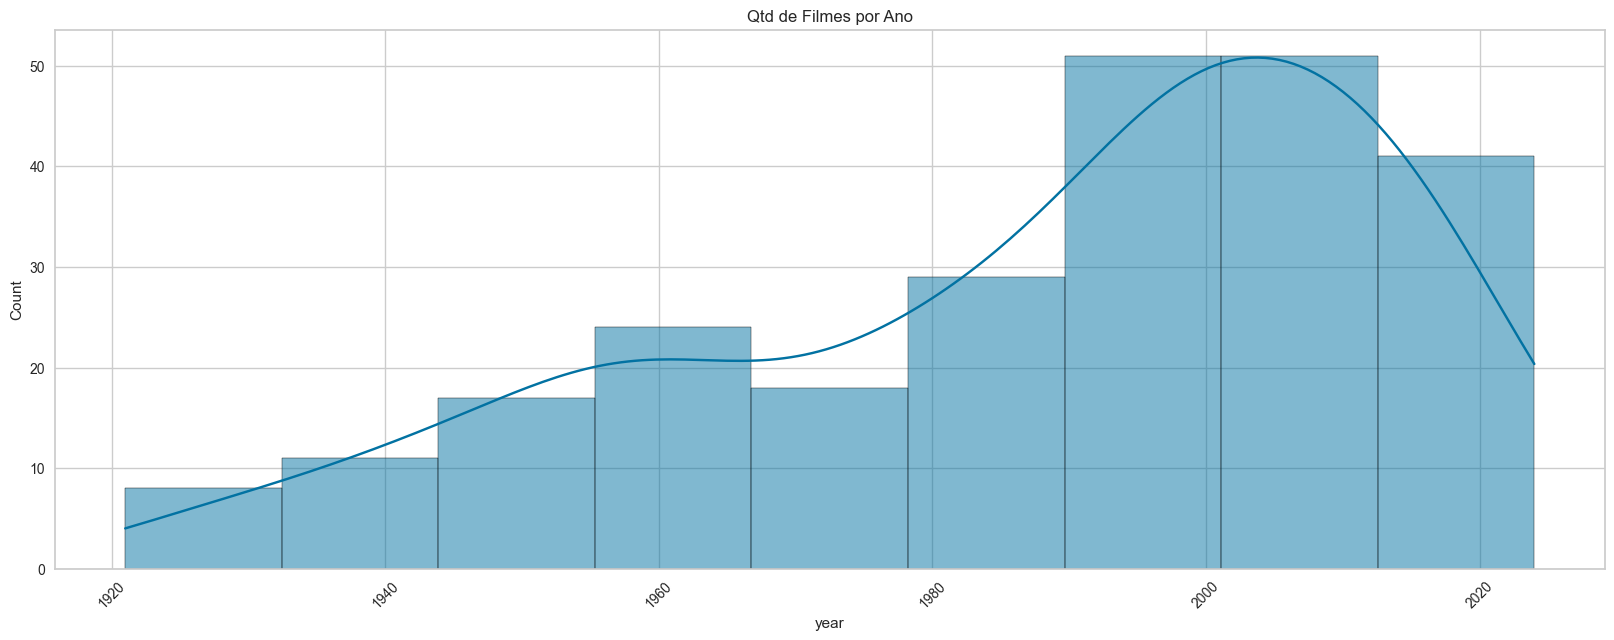

In [29]:
plt.figure(figsize = (20,7))
sns.histplot( df,
              x = 'year',
              kde = True).set_title('Qtd de Filmes por Ano')
plt.xticks(rotation=45)
plt.show()

C:\Users\Arthur Coutinho Sant\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Arthur Coutinho Sant\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Arthur Coutinho Sant\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Arthur Coutinho Sant\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Arthur Coutinho

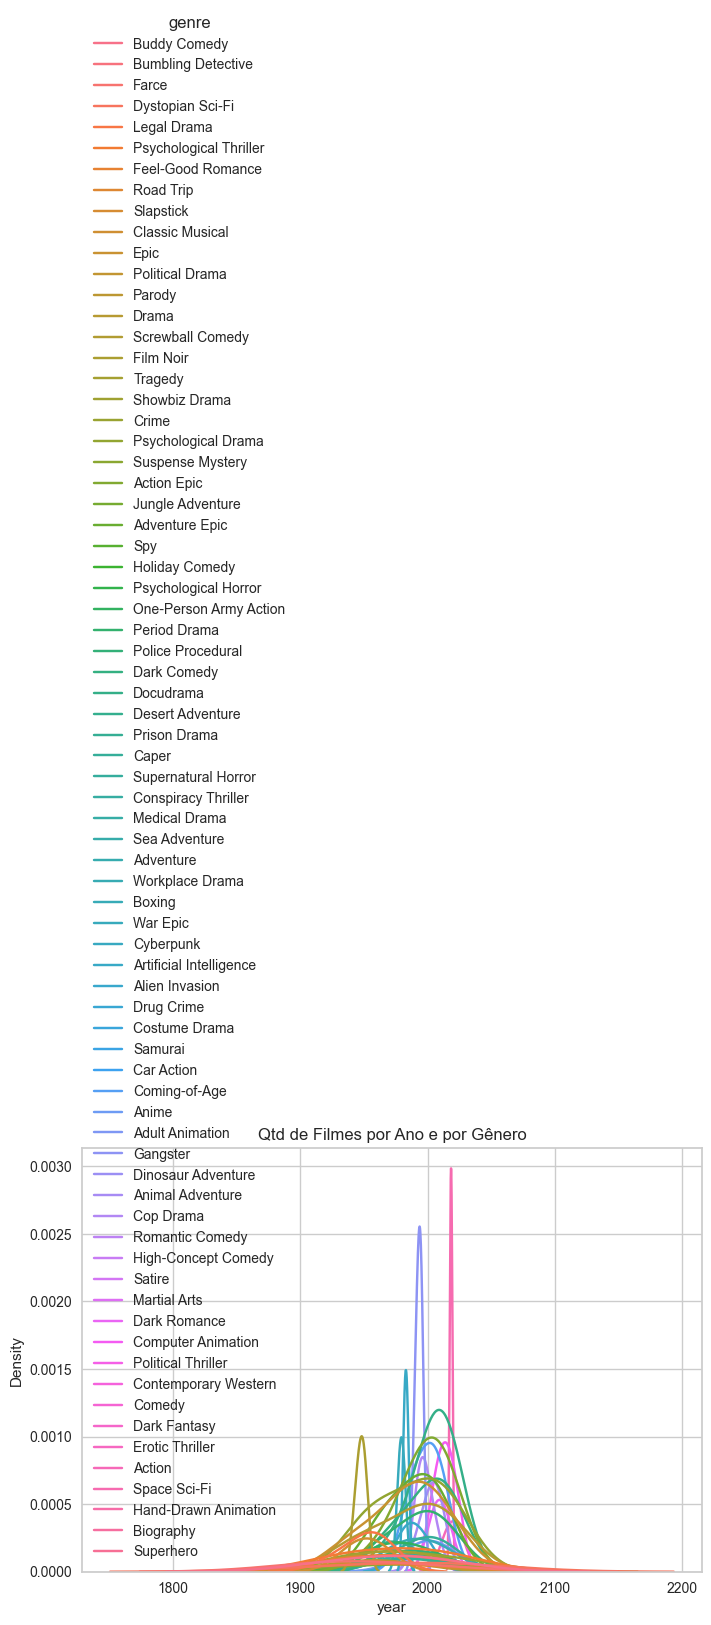

In [30]:
sns.kdeplot( df, x = 'year', hue = 'genre', bw_adjust = 1.5, warn_singular = False).set_title('Qtd de Filmes por Ano e por Gênero')
plt.show()

O grafico ficou com um entendimento muito ruim pela quantidade de generos diferentes, vamos agrupar pela similaridade

In [31]:
# Função para agrupar os gêneros
def agrupar_generos(genre):
    if 'Epic' in genre:
        return 'Épico'
    elif 'Comedy' in genre or 'Farce' in genre or 'Satire' in genre:
        return 'Comédia'
    elif 'Drama' in genre or 'Tragedy' in genre:
        return 'Drama'
    elif 'Action' in genre or 'Martial Arts' in genre:
        return 'Ação'
    elif 'Crime' in genre or 'Police Procedural' in genre or 'Gangster' in genre:
        return 'Crime'
    elif 'Animation' in genre:
        return 'Animação'
    elif 'Sci-Fi' in genre or 'Alien Invasion' in genre:
        return 'Ficção Científica'
    elif 'Adventure' in genre:
        return 'Aventura'
    elif 'Thriller' in genre or 'Conspiracy' in genre:
        return 'Suspense/Thriller'
    elif 'Romance' in genre:
        return 'Romance'
    elif 'Musical' in genre:
        return 'Musical'
    elif 'Horror' in genre or 'Fantasy' in genre:
        return 'Fantasia/Terror'
    elif 'Docudrama' in genre or 'Biography' in genre:
        return 'Documentário'
    else:
        return 'Outros'

# Aplicando o agrupamento no DataFrame
df['genre_grouped'] = df['genre'].apply(agrupar_generos)

C:\Users\Arthur Coutinho Sant\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Arthur Coutinho Sant\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Arthur Coutinho Sant\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Arthur Coutinho Sant\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Arthur Coutinho

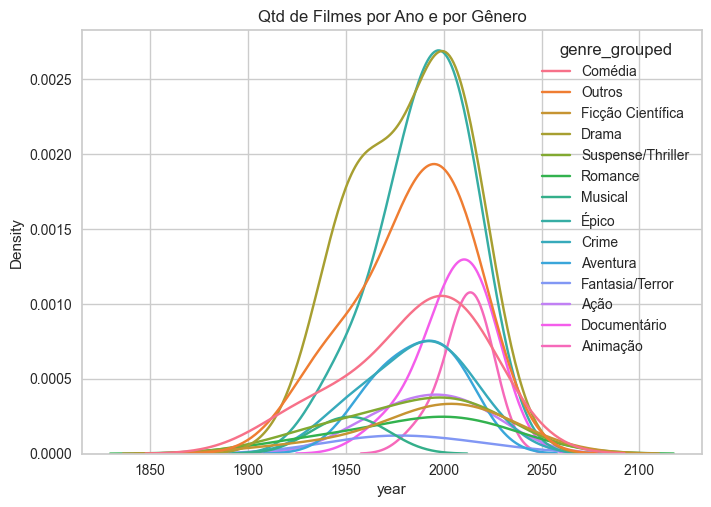

In [32]:
sns.kdeplot( df, x = 'year', hue = 'genre_grouped', bw_adjust = 1.5, warn_singular = False).set_title('Qtd de Filmes por Ano e por Gênero')
plt.show()

# Pré-processamento de texto

In [33]:
#convert sinopses to lowercase
df_processed = df.copy()
df_processed['sinopse'] = df_processed['sinopse'].str.lower()
df_processed['sinopse'].head()

133    um mendigo cuida de uma criança abandonada, ma...
199    um projecionista de cinema deseja ser um detet...
194    um garimpeiro vai ao klondike em busca de ouro...
198    uns espiões roubam a amada locomotiva de um en...
119    numa cidade futurística dividida entre os trab...
Name: sinopse, dtype: object

In [34]:
def qty_words(text):
    words= text.split()
    word_count = len(words)
    return word_count

In [35]:
df_processed['word_count'] = df_processed['sinopse'].apply(qty_words).astype('int64')
df_processed.head()

title_pt       title_en  year  rating               genre  \
133          O Garoto        The Kid  1921     8.2        Buddy Comedy   
199  Bancando o Águia                 1924     8.2  Bumbling Detective   
194  Em Busca do Ouro  The Gold Rush  1925     8.1               Farce   
198         A General    The General  1926     8.1               Farce   
119        Metrópolis     Metropolis  1927     8.3    Dystopian Sci-Fi   

                                               sinopse      genre_grouped  \
133  um mendigo cuida de uma criança abandonada, ma...            Comédia   
199  um projecionista de cinema deseja ser um detet...             Outros   
194  um garimpeiro vai ao klondike em busca de ouro...            Comédia   
198  uns espiões roubam a amada locomotiva de um en...            Comédia   
119  numa cidade futurística dividida entre os trab...  Ficção Científica   

     word_count  
133          13  
199          31  
194          15  
198          17  
119          20

C:\Users\Arthur Coutinho Sant\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Arthur Coutinho Sant\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Arthur Coutinho Sant\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Arthur Coutinho Sant\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Arthur Coutinho

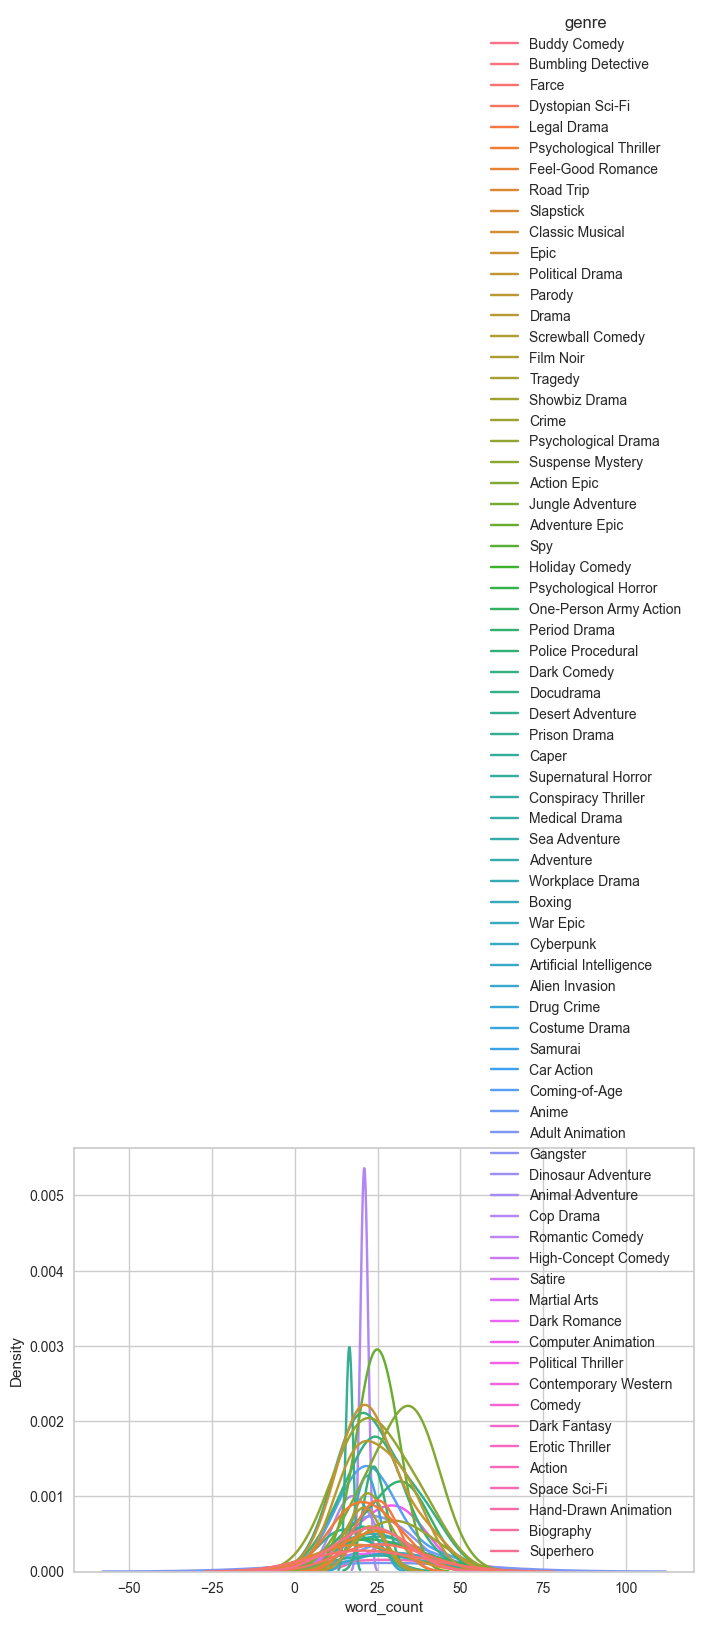

In [36]:
sns.kdeplot( df_processed, x = 'word_count', hue = 'genre', bw_adjust = 1.5, warn_singular = False)
plt.show()

Novamente iremos mostrar um grafico pelos generos agrupados

C:\Users\Arthur Coutinho Sant\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Arthur Coutinho Sant\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Arthur Coutinho Sant\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Arthur Coutinho Sant\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Arthur Coutinho

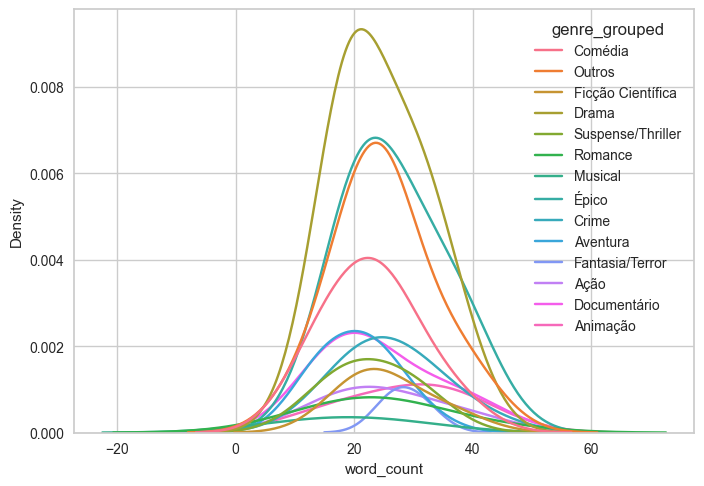

In [37]:
sns.kdeplot( df_processed, x = 'word_count', hue = 'genre_grouped', bw_adjust = 1.5, warn_singular = False)
plt.show()

## Nuvem de palavras

### Antes de remover stopwords

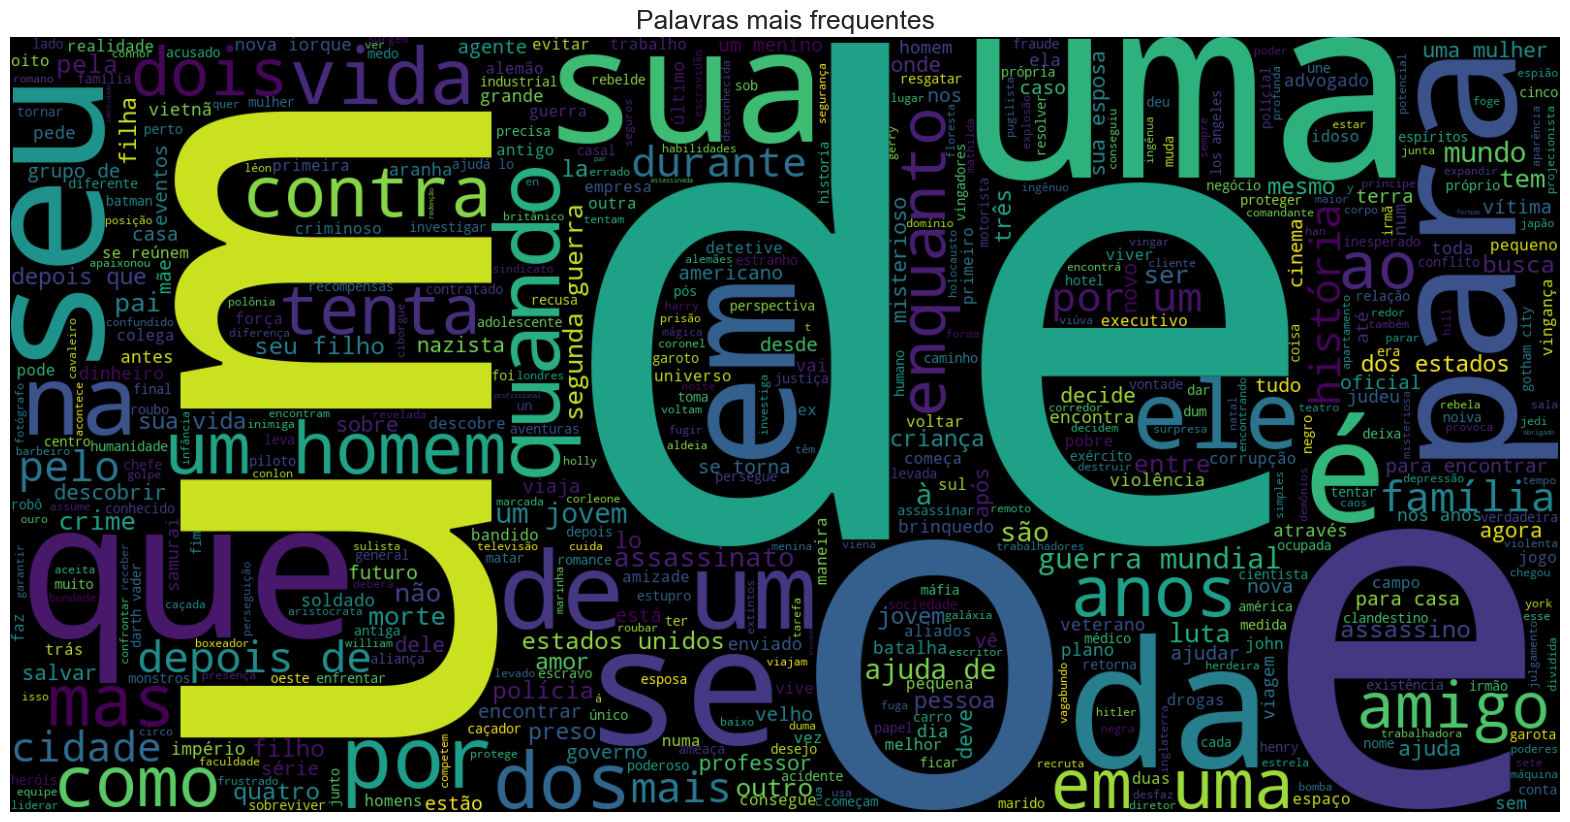

In [38]:
text = ' '.join([phrase for phrase in df_processed['sinopse']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Palavras mais frequentes', fontsize = 19)
plt.show()

### Após remoção das stopwords

In [39]:
import nltk
nltk.download('stopwords')

stopwords = nltk.corpus.stopwords.words('portuguese')
print(stopwords)

['a', 'à', 'ao', 'aos', 'aquela', 'aquelas', 'aquele', 'aqueles', 'aquilo', 'as', 'às', 'até', 'com', 'como', 'da', 'das', 'de', 'dela', 'delas', 'dele', 'deles', 'depois', 'do', 'dos', 'e', 'é', 'ela', 'elas', 'ele', 'eles', 'em', 'entre', 'era', 'eram', 'éramos', 'essa', 'essas', 'esse', 'esses', 'esta', 'está', 'estamos', 'estão', 'estar', 'estas', 'estava', 'estavam', 'estávamos', 'este', 'esteja', 'estejam', 'estejamos', 'estes', 'esteve', 'estive', 'estivemos', 'estiver', 'estivera', 'estiveram', 'estivéramos', 'estiverem', 'estivermos', 'estivesse', 'estivessem', 'estivéssemos', 'estou', 'eu', 'foi', 'fomos', 'for', 'fora', 'foram', 'fôramos', 'forem', 'formos', 'fosse', 'fossem', 'fôssemos', 'fui', 'há', 'haja', 'hajam', 'hajamos', 'hão', 'havemos', 'haver', 'hei', 'houve', 'houvemos', 'houver', 'houvera', 'houverá', 'houveram', 'houvéramos', 'houverão', 'houverei', 'houverem', 'houveremos', 'houveria', 'houveriam', 'houveríamos', 'houvermos', 'houvesse', 'houvessem', 'houvésse

[nltk_data] Downloading package stopwords to C:\Users\Arthur Coutinho
[nltk_data]     Sant\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


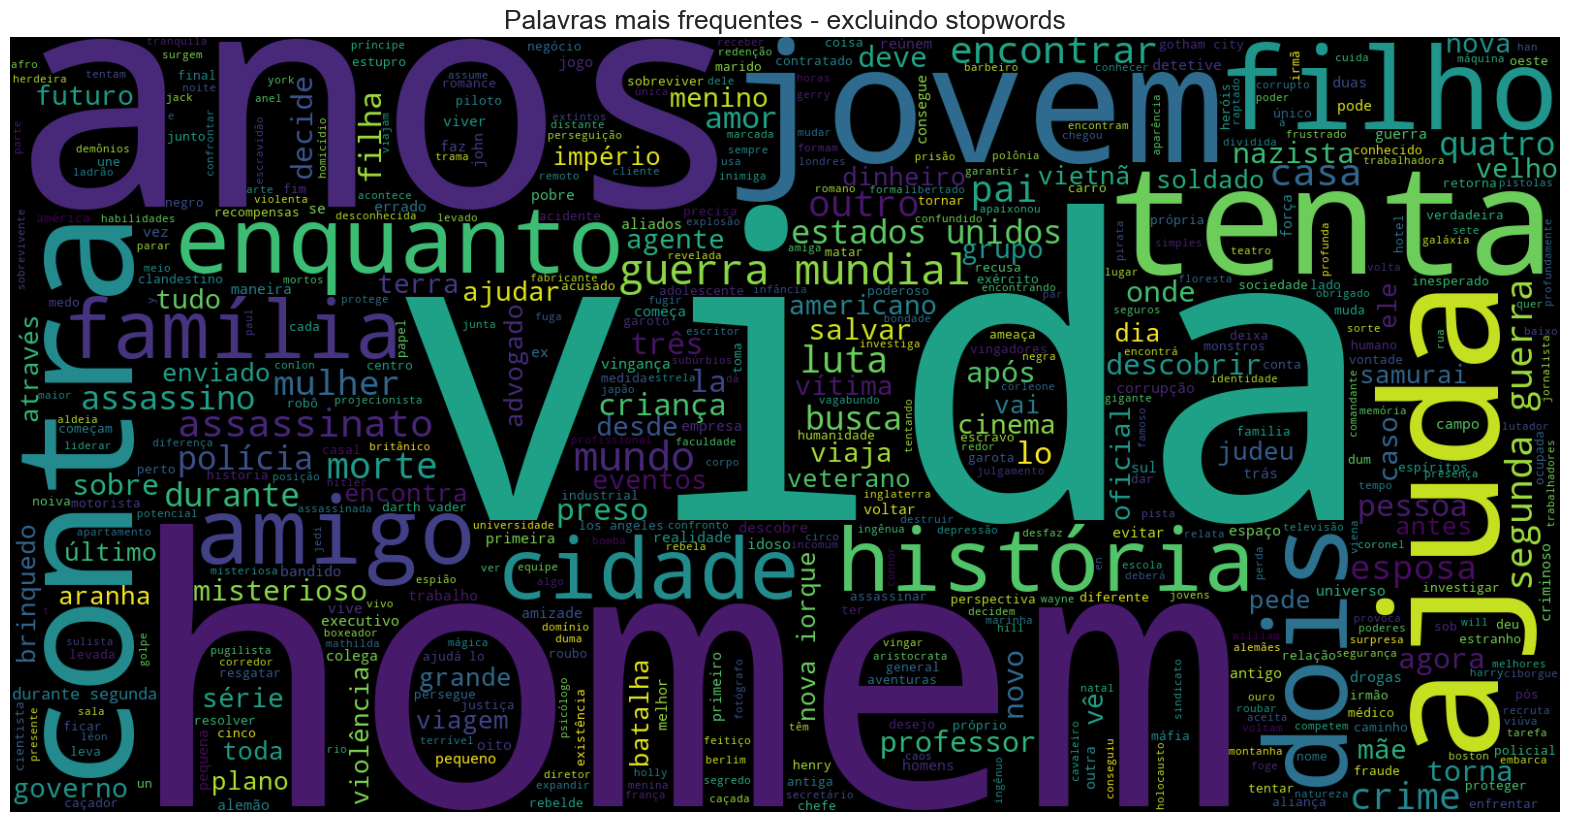

In [40]:
df_processed['sinopse_no_stopwords'] = df_processed['sinopse'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))
text = ' '.join([phrase for phrase in df_processed['sinopse_no_stopwords']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Palavras mais frequentes - excluindo stopwords', fontsize = 19)
plt.show()

## Aplicando TF-IDF

In [41]:
# initialize the vectorizer
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=.05, max_df=0.95, ngram_range=(1,2))
# fit_transform applies TF-IDF to clean texts - we save the array of vectors in X
X = vectorizer.fit_transform(df_processed['sinopse_no_stopwords'])

In [42]:
print(X.shape)
X.toarray()

(250, 14)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

# KMeans - Clusterização

## Escolhendo o numero de "k" clusters ideal

### Método Elbow

In [43]:
df_processed

title_pt  \
133                              O Garoto   
199                      Bancando o Águia   
194                      Em Busca do Ouro   
198                             A General   
119                            Metrópolis   
..                                    ...   
59                              Repetente   
102                           Oppenheimer   
36   Homem-Aranha: Através do Aranhaverso   
191                              Maharaja   
44                          Duna: Parte 2   

                                title_en  year  rating               genre  \
133                              The Kid  1921     8.2        Buddy Comedy   
199                                       1924     8.2  Bumbling Detective   
194                        The Gold Rush  1925     8.1               Farce   
198                          The General  1926     8.1               Farce   
119                           Metropolis  1927     8.3    Dystopian Sci-Fi   
..                                   ...   ...     ...                 ...   
59                             12th Fail  2023     8.9           Docudrama   
102                          Oppenheimer  2023     8.3           Docudrama   
36   Spider-Man: Across the Spider-Verse  2023     8.6  Computer Animation   
191                             Maharaja  2024     8.5              Action   
44                        Dune: Part Two  2024     8.5         Action Epic   

                                               sinopse      genre_grouped  \
133  um mendigo cuida de uma criança abandonada, ma...            Comédia   
199  um projecionista de cinema deseja ser um detet...             Outros   
194  um garimpeiro vai ao klondike em busca de ouro...            Comédia   
198  uns espiões roubam a amada locomotiva de um en...            Comédia   
119  numa cidade futurística dividida entre os trab...  Ficção Científica   
..                                                 ...                ...   
59   a história da vida real do oficial do ips mano...       Documentário   
102  a história do cientista americano j. robert op...       Documentário   
36   viajando pelo multiverso, miles morales conhec...           Animação   
191  um barbeiro busca vingança depois que sua casa...               Ação   
44   diante da difícil escolha entre o amor de sua ...              Épico   

     word_count                               sinopse_no_stopwords  
133          13  mendigo cuida criança abandonada, eventos amea...  
199          31  projecionista cinema deseja detetive coloca ma...  
194          15  garimpeiro vai klondike busca ouro encontra isso.  
198          17  uns espiões roubam amada locomotiva engenheiro...  
119          20  cidade futurística dividida trabalhadores plan...  
..          ...                                                ...  
59           19  história vida real oficial ips manoj kumar sha...  
102          16  história cientista americano j. robert oppenhe...  
36           37  viajando multiverso, miles morales conhece nov...  
191          37  barbeiro busca vingança casa assaltada, dizend...  
44           40  diante difícil escolha amor vida destino unive...  

[250 rows x 9 columns]

2 130.2744225831224
3 117.26937646307586
4 105.80144969678607
5 89.29985082951583
6 80.52671857049852
7 69.40500890703716
8 60.639846971648986
9 54.60637779811549
10 45.32920229666844
11 35.33676692973717
12 33.56154304554349
13 29.7750706826977
14 24.757440768617737
15 23.785075861968608
16 23.442182855570607
17 21.90854000158361
18 21.18942681460872
19 20.855457083444406
20 18.93705584284718
21 18.204648962366733
22 16.864933186491534
23 15.734897593660826
24 15.86620349364999
25 14.592594732730898
26 14.864208041034146
27 13.511681517178436
28 13.393408965084562
29 11.6015367625034
30 11.822728476431859
31 10.617667569076012
32 9.639011941297941
33 9.819352248196342
34 10.00814002770763
35 9.106786865321755
36 8.273401747543923
37 7.579112512223632
38 6.891719610803212
39 6.4669597684797955
40 5.358659164635734
41 6.026682404781886
42 5.443690806416969
43 4.892810736565765
44 4.219206679938588
45 3.4274959717403015
46 2.5025158380496255
47 2.3401167380950842
48 2.091762942934734
49 

Text(0, 0.5, 'WCSS')

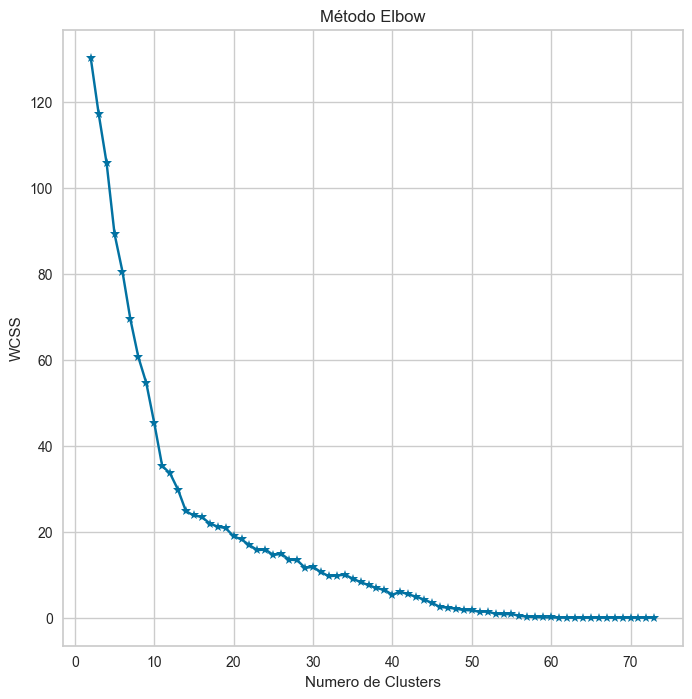

In [52]:
plt.figure(figsize = (8,8))

#plotando o grafico do método elbow
wcss = []

for i in range(2, df_processed.genre.nunique()+1):
  kmeans = KMeans(n_clusters = i, init = 'random')
  kmeans.fit(X)
  print(i, kmeans.inertia_)
  wcss.append(kmeans.inertia_)

plt.plot(range(2, df_processed.genre.nunique()+1), wcss, '*-')
plt.title('Método Elbow')
plt.xlabel('Numero de Clusters')
plt.ylabel('WCSS') #within cluster sum of square


### Método Silhouette

In [45]:
df_processed.genre.nunique()

73

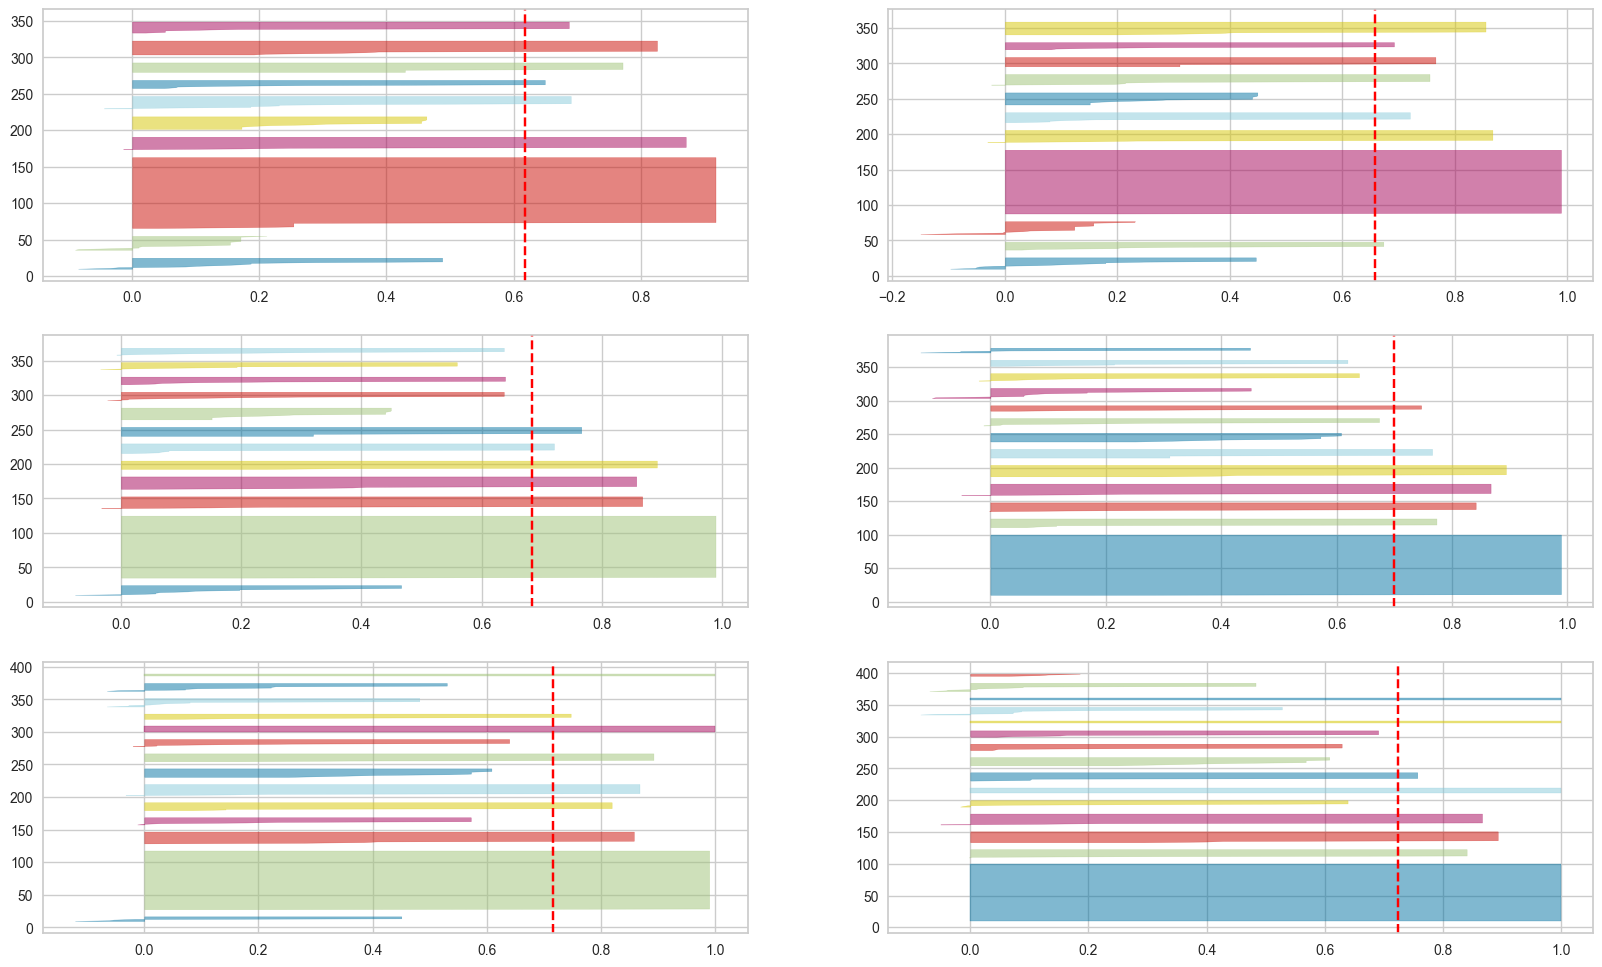

In [55]:
# fig, ax = plt.subplots(3,2, figsize = (20,12))
# for i in (range(10, 17)):
#   #Creating KMeans instance for different number of clusters
#   kmeans = KMeans(n_clusters = i, init = 'k-means++', n_init = 10, max_iter = 100, random_state = 42)
#   q, mod = divmod(i,2)

#   #Creating SilhouetteVisualizer instance with KMeans instance
#   #Fit the visualizer

#   visualizer = SilhouetteVisualizer(kmeans, colors = 'yellowbrick', ax = ax[q-1][mod])
#   visualizer.fit(X)

fig, ax = plt.subplots(3,2, figsize = (20,12))
for i in range(6):  # Adjusted loop to match the number of subplots
    #Creating KMeans instance for different number of clusters
    kmeans = KMeans(n_clusters = i + 10, init = 'k-means++', n_init = 10, max_iter = 100, random_state = 42)
    q, mod = divmod(i, 2)  # Calculate row and column indices

    #Creating SilhouetteVisualizer instance with KMeans instance
    #Fit the visualizer

    visualizer = SilhouetteVisualizer(kmeans, colors = 'yellowbrick', ax = ax[q][mod])  # Access correct subplot
    visualizer.fit(X)

### Análise do número de clusters (texto ajustado para nova analise)
* O método de elbow indicou um numero de k ideal entre 10 e 20. Pelo método de Silhouete não ficou muito claro, como foi definido usarmos 5 clusters pelo enunciado, nao diferenciaremos um estudo de generos agrupados e nao agrupados

# Comparativo entre os 5 clusters

In [57]:
# initialize kmeans with 5 centroids
kmeans = KMeans(n_clusters=5, random_state=42)
# fit the model
kmeans = kmeans.fit(X)
#predicting the clusters and store cluster labels in a variable
labels = kmeans.predict(X)
#getting the cluster centers
c = kmeans.cluster_centers_

df_processed['cluster'] = labels
df_processed.head()

title_pt       title_en  year  rating               genre  \
133          O Garoto        The Kid  1921     8.2        Buddy Comedy   
199  Bancando o Águia                 1924     8.2  Bumbling Detective   
194  Em Busca do Ouro  The Gold Rush  1925     8.1               Farce   
198         A General    The General  1926     8.1               Farce   
119        Metrópolis     Metropolis  1927     8.3    Dystopian Sci-Fi   

                                               sinopse      genre_grouped  \
133  um mendigo cuida de uma criança abandonada, ma...            Comédia   
199  um projecionista de cinema deseja ser um detet...             Outros   
194  um garimpeiro vai ao klondike em busca de ouro...            Comédia   
198  uns espiões roubam a amada locomotiva de um en...            Comédia   
119  numa cidade futurística dividida entre os trab...  Ficção Científica   

     word_count                               sinopse_no_stopwords  cluster  
133          13  mendigo cuida criança abandonada, eventos amea...        1  
199          31  projecionista cinema deseja detetive coloca ma...        1  
194          15  garimpeiro vai klondike busca ouro encontra isso.        1  
198          17  uns espiões roubam amada locomotiva engenheiro...        1  
119          20  cidade futurística dividida trabalhadores plan...        2

## Filmes por cluster

In [58]:
fig = px.bar(df_processed.cluster.value_counts(),
             text_auto = True,
             title = 'Qtd de Filmes por Cluster',
             labels = {'index': 'Cluster #',
                       'value':'Qtd. de Filmes'})
fig.show()

## % de Gêneros Não Agrupados por Cluster

C:\Users\Arthur Coutinho Sant\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Arthur Coutinho Sant\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Arthur Coutinho Sant\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Arthur Coutinho Sant\AppData\Roaming\Python\Python311\site-packages\seaborn\categorical.py:3201: UserWarning:

Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.

C:\U

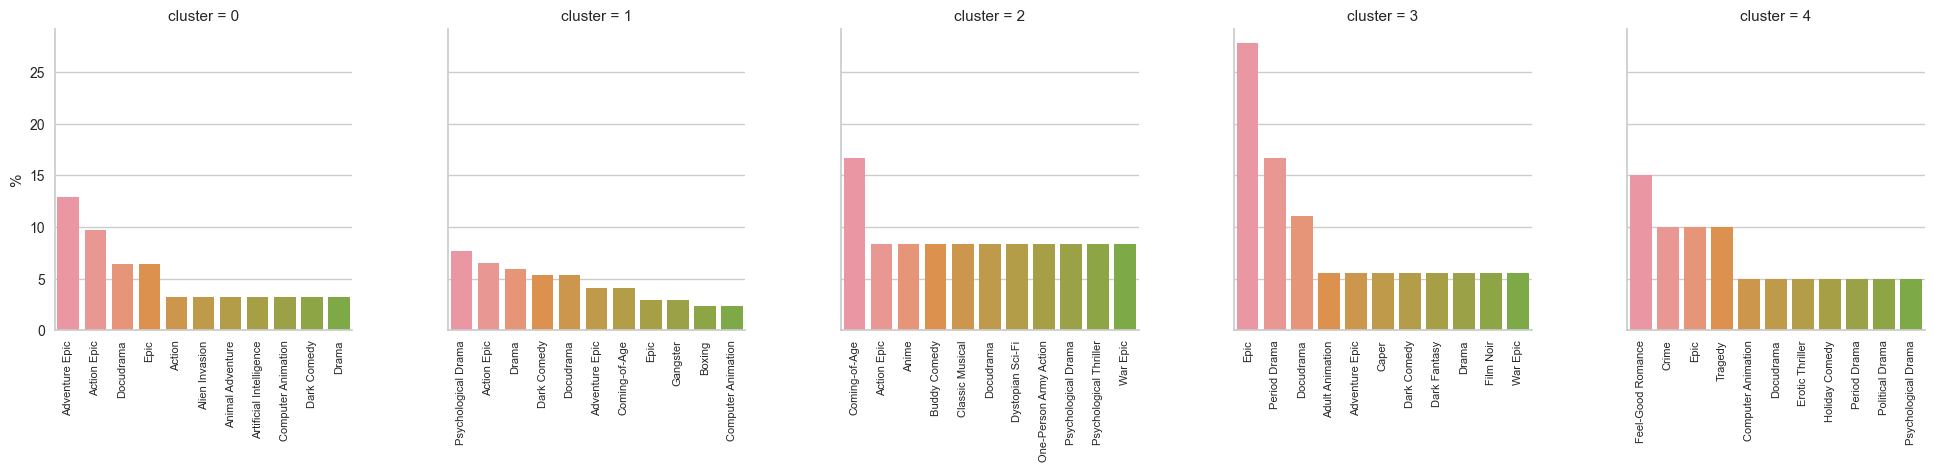

In [68]:
df_plot = df_processed.groupby(['cluster', 'genre'])['title_pt'].count()
df_plot = df_plot.reset_index()
df_plot.rename(columns = {'title_pt':'count'}, inplace = True)
df_plot['%'] = 100 * df_plot['count'] / df_plot.groupby('cluster')['count'].transform('sum')
df_plot = df_plot.sort_values(['cluster', '%'], ascending = False).groupby('cluster').head(11)

fig = sns.catplot(
    data=df_plot, x="genre", y = "%", col="cluster",
    kind="bar", height=4, aspect=1, sharex = False);
fig.set_xlabels('');
fig.set_xticklabels(rotation=90, size = 8);

## % de Gêneros Agrupados por Cluster

C:\Users\Arthur Coutinho Sant\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Arthur Coutinho Sant\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Arthur Coutinho Sant\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Arthur Coutinho Sant\AppData\Roaming\Python\Python311\site-packages\seaborn\categorical.py:3201: UserWarning:

Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.

C:\U

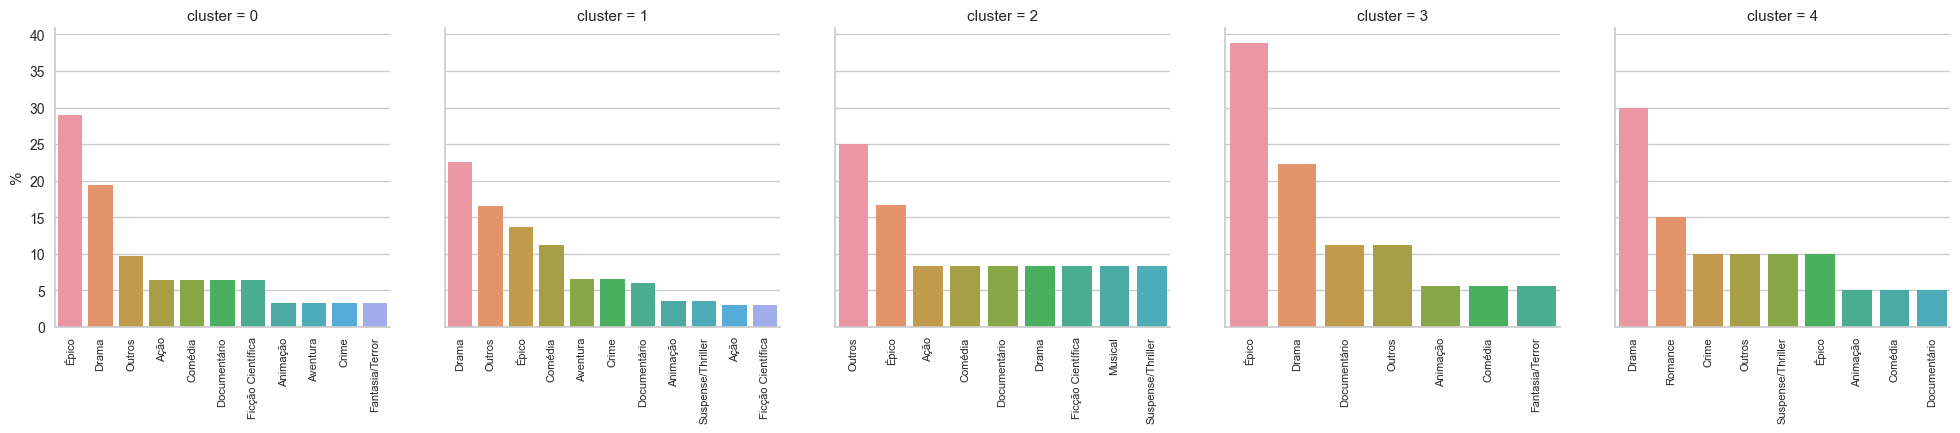

In [73]:
df_plot = df_processed.groupby(['cluster', 'genre_grouped'])['title_pt'].count()
df_plot = df_plot.reset_index()
df_plot.rename(columns = {'title_pt':'count'}, inplace = True)
df_plot['%'] = 100 * df_plot['count'] / df_plot.groupby('cluster')['count'].transform('sum')
df_plot = df_plot.sort_values(['cluster', '%'], ascending = False).groupby('cluster').head(11)

fig = sns.catplot(
    data=df_plot, x="genre_grouped", y = "%", col="cluster",
    kind="bar", height=4, aspect=1, sharex = False);
fig.set_xlabels('');
fig.set_xticklabels(rotation=90, size = 8);

## Ano de Lançamento por Cluster

C:\Users\Arthur Coutinho Sant\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Arthur Coutinho Sant\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Arthur Coutinho Sant\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



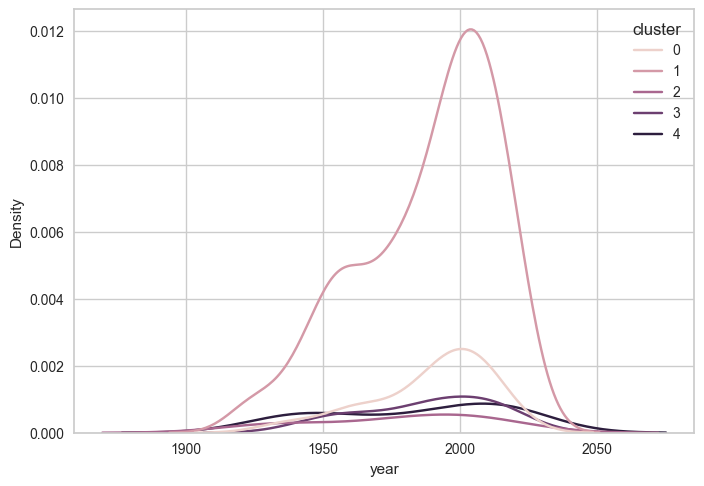

In [64]:
sns.kdeplot(df_processed, x = 'year', hue = 'cluster');

## Radar | Gêneros por Cluster

In [69]:
df_pivot = df_plot.copy()
df_pivot = df_pivot.pivot(index = 'cluster', columns = 'genre', values = '%')
df_pivot.fillna(0, inplace = True)
df_pivot = df_pivot.T.reset_index()
df_pivot.index.name = None
df_pivot

cluster                    genre          0         1          2          3  \
0                         Action   3.225806  0.000000   0.000000   0.000000   
1                    Action Epic   9.677419  6.508876   8.333333   0.000000   
2                Adult Animation   0.000000  0.000000   0.000000   5.555556   
3                 Adventure Epic  12.903226  4.142012   0.000000   5.555556   
4                 Alien Invasion   3.225806  0.000000   0.000000   0.000000   
5               Animal Adventure   3.225806  0.000000   0.000000   0.000000   
6                          Anime   0.000000  0.000000   8.333333   0.000000   
7        Artificial Intelligence   3.225806  0.000000   0.000000   0.000000   
8                         Boxing   0.000000  2.366864   0.000000   0.000000   
9                   Buddy Comedy   0.000000  0.000000   8.333333   0.000000   
10                         Caper   0.000000  0.000000   0.000000   5.555556   
11               Classic Musical   0.000000  0.000000   8.333333   0.000000   
12                 Coming-of-Age   0.000000  4.142012  16.666667   0.000000   
13            Computer Animation   3.225806  2.366864   0.000000   0.000000   
14                         Crime   0.000000  0.000000   0.000000   0.000000   
15                   Dark Comedy   3.225806  5.325444   0.000000   5.555556   
16                  Dark Fantasy   0.000000  0.000000   0.000000   5.555556   
17                     Docudrama   6.451613  5.325444   8.333333  11.111111   
18                         Drama   3.225806  5.917160   0.000000   5.555556   
19              Dystopian Sci-Fi   0.000000  0.000000   8.333333   0.000000   
20                          Epic   6.451613  2.958580   0.000000  27.777778   
21               Erotic Thriller   0.000000  0.000000   0.000000   0.000000   
22             Feel-Good Romance   0.000000  0.000000   0.000000   0.000000   
23                     Film Noir   0.000000  0.000000   0.000000   5.555556   
24                      Gangster   0.000000  2.958580   0.000000   0.000000   
25                Holiday Comedy   0.000000  0.000000   0.000000   0.000000   
26        One-Person Army Action   0.000000  0.000000   8.333333   0.000000   
27                  Period Drama   0.000000  0.000000   0.000000  16.666667   
28               Political Drama   0.000000  0.000000   0.000000   0.000000   
29           Psychological Drama   0.000000  7.692308   8.333333   0.000000   
30        Psychological Thriller   0.000000  0.000000   8.333333   0.000000   
31                       Tragedy   0.000000  0.000000   0.000000   0.000000   
32                      War Epic   0.000000  0.000000   8.333333   5.555556   

cluster     4  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0  
5         0.0  
6         0.0  
7         0.0  
8         0.0  
9         0.0  
10        0.0  
11        0.0  
12        0.0  
13        5.0  
14       10.0  
15        0.0  
16        0.0  
17        5.0  
18        0.0  
19        0.0  
20       10.0  
21        5.0  
22       15.0  
23        0.0  
24        0.0  
25        5.0  
26        0.0  
27        5.0  
28        5.0  
29        5.0  
30        0.0  
31       10.0  
32        0.0

In [70]:
df_polar = df_pivot.melt(id_vars=['genre'])
df_polar.head()

genre cluster      value
0           Action       0   3.225806
1      Action Epic       0   9.677419
2  Adult Animation       0   0.000000
3   Adventure Epic       0  12.903226
4   Alien Invasion       0   3.225806

In [71]:
fig = px.line_polar(df_polar, r='value', theta='genre', color = 'cluster', line_close=True)
fig.show();

## Radar | Gêneros Agrupados por Cluster

In [74]:
df_pivot = df_plot.copy()
df_pivot = df_pivot.pivot(index = 'cluster', columns = 'genre_grouped', values = '%')
df_pivot.fillna(0, inplace = True)
df_pivot = df_pivot.T.reset_index()
df_pivot.index.name = None
df_pivot

cluster      genre_grouped          0          1          2          3     4
0                 Animação   3.225806   3.550296   0.000000   5.555556   5.0
1                 Aventura   3.225806   6.508876   0.000000   0.000000   0.0
2                     Ação   6.451613   2.958580   8.333333   0.000000   0.0
3                  Comédia   6.451613  11.242604   8.333333   5.555556   5.0
4                    Crime   3.225806   6.508876   0.000000   0.000000  10.0
5             Documentário   6.451613   5.917160   8.333333  11.111111   5.0
6                    Drama  19.354839  22.485207   8.333333  22.222222  30.0
7          Fantasia/Terror   3.225806   0.000000   0.000000   5.555556   0.0
8        Ficção Científica   6.451613   2.958580   8.333333   0.000000   0.0
9                  Musical   0.000000   0.000000   8.333333   0.000000   0.0
10                  Outros   9.677419  16.568047  25.000000  11.111111  10.0
11                 Romance   0.000000   0.000000   0.000000   0.000000  15.0
12       Suspense/Thriller   0.000000   3.550296   8.333333   0.000000  10.0
13                   Épico  29.032258  13.609467  16.666667  38.888889  10.0

In [75]:
df_polar = df_pivot.melt(id_vars=['genre_grouped'])
df_polar.head()

genre_grouped cluster     value
0      Animação       0  3.225806
1      Aventura       0  3.225806
2          Ação       0  6.451613
3       Comédia       0  6.451613
4         Crime       0  3.225806

In [76]:
fig = px.line_polar(df_polar, r='value', theta='genre_grouped', color = 'cluster', line_close=True)
fig.show();

# Nuvem de Palavras por Cluster

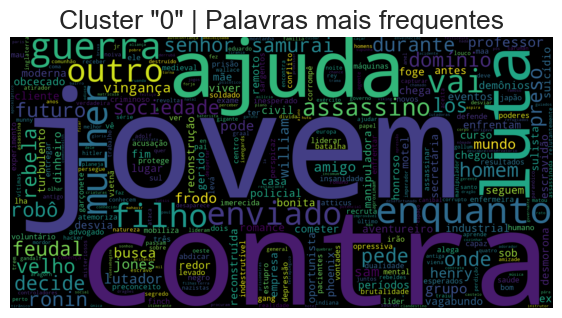

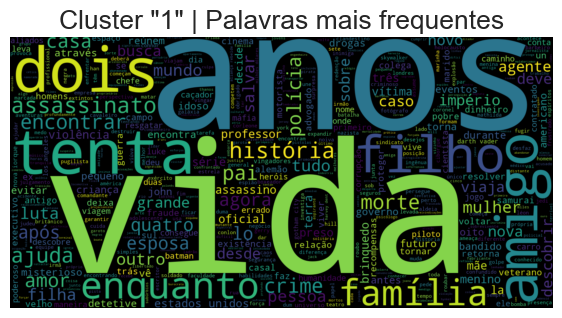

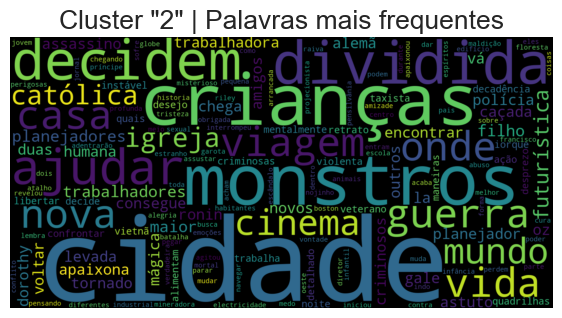

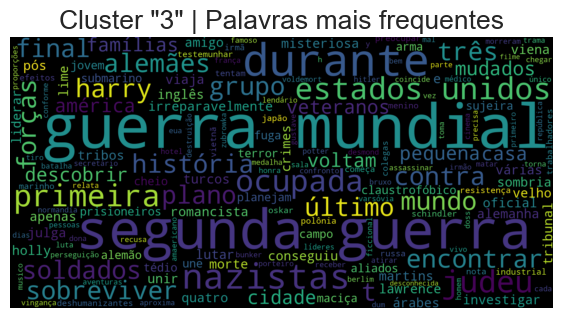

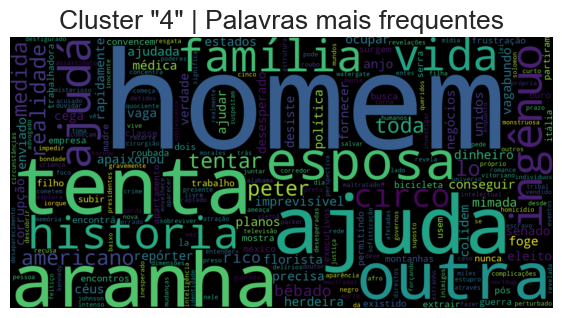

In [77]:
def word_cloud_cluster(cluster:int):
  text = ' '.join([phrase for phrase in df_processed.loc[df_processed.cluster == cluster]['sinopse_no_stopwords']])
  plt.figure(figsize=(7,5), facecolor='None')
  wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.title(f'Cluster "{cluster}" | Palavras mais frequentes', fontsize = 19)
  plt.show()
  return

for c in range(5):
  word_cloud_cluster(c)

# **Nomes dos Integrantes**:

## RM97804 - Arthur Coutinho Santos
## RM99589 - Luis Gustavo Dias da Silva
## RM98244 - Nicolas Felippe Gonçalves
## RM99221 - Guilherme Garcia Paschoalinoto

# **Analises:**

## Análise do gráfico "% de Filmes por Gênero"

Observamos uma ampla variedade de gêneros no gráfico, refletindo a diversidade de estilos cinematográficos. No entanto, dada a quantidade significativa de categorias, pode ser necessário agrupar ou filtrar os gêneros menos representativos para facilitar a visualização e análise. Outro ponto relevante é a disparidade nas porcentagens entre os gêneros. Enquanto alguns gêneros mais populares, como *Drama Psicológico*, representam uma grande fatia (6,4%), outros, como *Cyberpunk*, aparecem com apenas 0,4%. Isso pode refletir a produção voltada para o grande público versus nichos mais específicos. É interessante observar como a indústria de cinema prioriza certos gêneros para alcançar grandes audiências, enquanto gêneros mais alternativos atendem a públicos específicos.

## Análise do gráfico "Quantidade de Filmes por Ano"

O gráfico mostra uma tendência de crescimento na produção de filmes ao longo dos anos, o que oferece várias possibilidades de análise. Essa ascensão pode ser atribuída à popularização do cinema no início do século 20 e à evolução tecnológica que trouxe inovações como o cinema falado e os filmes em cores, por volta de 1920. O gráfico também destaca um aumento expressivo a partir de 1990, que pode estar relacionado ao surgimento do IMDb, uma plataforma que impulsionou o engajamento e a visibilidade de filmes. Infelizmente, muitos filmes lançados antes desse período podem ter perdido relevância e não recebem o mesmo destaque nas plataformas modernas, contribuindo para essa diferença nos números.


## Análise do gráfico "Quantidade de Filmes por Ano e por Gênero"

### Tivemos que agrupar os generos devido a alta quantidade no top 250 do IMDB, fazendo uma nova coluna de generos agrupados, com categorias mais amplas

1. **Pico de Produção por Gênero**:
   O gráfico mostra que a maior parte da produção cinematográfica, independentemente do gênero, teve um pico entre o final dos anos 1990 e início dos anos 2000. Esse comportamento pode ser explicado por uma série de fatores, como o desenvolvimento tecnológico que facilitou a produção e distribuição de filmes, além do crescimento das plataformas de avaliação como o IMDb, que aumentou a visibilidade e o engajamento com os filmes.

2. **Domínio de Certos Gêneros**:
   Gêneros como *Drama* e *Épico* parecem ser os mais proeminentes, com um pico muito acentuado em torno dos anos 2000. Isso faz sentido, dado que dramas costumam ser amplamente valorizados tanto por críticos quanto pelo público, sendo frequentemente escolhidos para representar grandes produções no cinema. Já o gênero épico pode ter crescido com o aumento dos efeitos visuais avançados e a capacidade de criar grandes narrativas visuais com o avanço da tecnologia.

3. **Outros Gêneros com Picos Visíveis**:
   Gêneros como *Ação*, *Suspense/Thriller* e *Ficção Científica* também mostram picos significativos, embora em uma escala menor. Esses gêneros tendem a apelar para públicos que buscam adrenalina e inovação tecnológica, o que pode justificar o crescimento em paralelo à ascensão de franquias de sucesso como *Star Wars* e *Matrix*.

4. **Gêneros Menos Representativos**:
   Gêneros como *Musical*, *Animação*, *Fantasia/Terror* e *Romance* têm uma participação menor na produção geral, mas ainda apresentam relevância em momentos específicos. Isso pode refletir tanto uma demanda menor do público como um foco mais nichado na criação desses tipos de filmes.

5. **Impacto do IMDb no Engajamento**:
   O gráfico também reforça a ideia de que o surgimento do IMDb, nos anos 1990, pode ter impactado a visibilidade e o registro dos filmes. A partir dessa época, a quantidade de filmes no top 250 cresceu exponencialmente, possivelmente devido ao aumento de plataformas que facilitam a avaliação pública e promovem o engajamento com grandes produções.

6. **Desaceleração Pós-2000**:
   É interessante observar a desaceleração da produção após 2010, o que pode estar relacionado à saturação de certos gêneros ou à mudança nos hábitos de consumo de mídia, com o crescimento do streaming e outras formas de entretenimento. O gráfico sugere que os filmes lançados mais recentemente têm um impacto menor no top 250 do IMDb, o que também pode estar relacionado a mudanças nos critérios de avaliação.

## Análise do gráfico "Densidade de Contagem de Palavras por Gênero"

1. **Distribuição Geral**:
   O gráfico apresenta a densidade da contagem de palavras nas sinopses dos filmes, segmentada por gênero agrupado. Notamos que a maioria dos gêneros segue um padrão concentrado entre 10 a 40 palavras, com picos mais acentuados em torno de 20 a 25 palavras. Isso indica que, em média, as sinopses de filmes não são muito longas e mantêm uma estrutura compacta e direta ao ponto.

2. **Gênero *Drama***:
   O gênero *Drama* destaca-se com a maior densidade em relação à contagem de palavras, com um pico bem definido em torno de 20 palavras. Este comportamento sugere que sinopses de filmes dramáticos tendem a ser mais concisas, provavelmente com foco em transmitir a essência emocional da trama de maneira resumida.

3. **Comédia e Romance**:
   Gêneros como *Comédia* e *Romance* também apresentam uma alta densidade em torno de 20 palavras, mas com uma curva um pouco mais distribuída em relação aos dramas. Isso pode refletir o fato de que sinopses nesses gêneros frequentemente precisam equilibrar informações sobre o enredo com o tom humorístico ou romântico da história, sem se prolongar muito.

4. **Gêneros com Sinopses Mais Longas**:
   Gêneros como *Suspense/Thriller* e *Ficção Científica* apresentam uma distribuição mais alargada, sugerindo que as sinopses nesses gêneros podem ser um pouco mais detalhadas, chegando até 40 palavras ou mais. Isso faz sentido, considerando que esses gêneros muitas vezes exigem explicações mais detalhadas para situar o público em universos complexos ou em tramas de suspense.

5. **Gêneros Menos Representativos**:
   Gêneros como *Musical*, *Documentário* e *Fantasia/Terror* possuem curvas menos acentuadas, sugerindo que suas sinopses podem variar mais em termos de tamanho. É possível que esses gêneros adotem abordagens variadas na criação de sinopses, dependendo do público-alvo ou do estilo da narrativa.

6. **Outros Gêneros**:
   *Épico* e *Aventura* também possuem distribuições mais amplas, o que pode estar relacionado à necessidade de contextualizar narrativas maiores ou com mais detalhes de ambientação, especialmente em sinopses que buscam capturar a grandiosidade da história.

## Análise da Nuvem de Palavras "Palavras mais frequentes - excluindo stopwords"

1. **Palavras em Destaque**:
   As palavras mais destacadas visualmente na nuvem incluem *vida*, *homem*, *enquanto*, *anos*, *cidade*, *história*, *morte* e *amigo*. Essas palavras indicam os temas centrais mais frequentes nas sinopses dos filmes, sugerindo que muitas tramas giram em torno de experiências humanas, desafios e relações pessoais.

2. **Temas Repetitivos**:
   Observamos também a presença de termos relacionados a *família*, *guerra*, *polícia*, *crime*, *assassinato* e *luta*. Isso sugere que uma grande parte das histórias no top 250 do IMDb envolvem dramas familiares, conflitos armados, investigação policial e atos de violência. Esses temas são comuns em filmes de ação, suspense e drama, refletindo a preferência por narrativas intensas e emocionalmente envolventes.

3. **Histórias de Superação e Conflito**:
   Palavras como *salva*, *veterano*, *guerra mundial*, *preso*, *busca*, *ajuda* e *sobrevivente* indicam que muitas tramas são focadas em superação, sobrevivência e conflitos em cenários de guerra. Isso pode apontar para um forte componente de resiliência nas histórias contadas nos filmes, frequentemente retratando protagonistas que enfrentam grandes adversidades.

4. **Outros Elementos de Enredo**:
   Também notamos palavras como *professor*, *advogado*, *agente*, *criança*, *judeu*, *esposa* e *filho*, o que sugere a presença de diversos personagens com papéis centrais variados, desde figuras de autoridade até relações familiares. Além disso, termos como *segredo*, *misterioso*, *descobrir* e *crime* reforçam a popularidade de enredos envolvendo mistérios e investigações.

5. **Períodos Históricos**:
   A presença de termos como *segunda guerra mundial*, *nazista* e *anos* indica uma forte conexão com eventos históricos, especialmente a Segunda Guerra Mundial, um tema que é frequentemente abordado em filmes épicos e dramas históricos.

6. **Exploração de Cidades e Viagens**:
   Palavras como *cidade*, *viajar*, *mundo* e *universo* mostram que muitos filmes exploram não só o ambiente urbano, mas também aventuras globais ou até intergalácticas. Isso reflete uma gama de cenários diversificados, desde dramas urbanos até aventuras épicas de ficção científica.

## Análise do Gráfico "Qtd de Filmes por Cluster"

1. **Distribuição Desigual entre os Clusters**:
   O gráfico de barras mostra a quantidade de filmes distribuída em 5 clusters (0 a 4). Podemos observar uma distribuição bastante desigual entre os clusters. O **cluster 1** é o mais populoso, com **169 filmes**, enquanto os demais clusters têm significativamente menos filmes, como **31 filmes no cluster 0**, **12 filmes no cluster 2**, **18 no cluster 3**, e **20 no cluster 4**.

2. **Cluster Dominante**:
   O **cluster 1** domina a distribuição, com mais de 70% do total de filmes. Isso indica que um grande número de filmes compartilha características similares, o que pode significar uma predominância de certos gêneros ou características específicas dentro desse cluster.

3. **Clusters Menores**:
   Os clusters 0, 2, 3 e 4 possuem uma quantidade significativamente menor de filmes, sugerindo que estes clusters estão capturando grupos menores e mais específicos de filmes que compartilham características menos comuns.

4. **Possível Sobreamostragem de Características**:
   A grande disparidade entre o número de filmes no cluster 1 em comparação aos demais pode sugerir que as características que definem esse cluster são muito comuns entre os filmes analisados, enquanto os outros clusters podem representar filmes com características mais específicas ou menos comuns.

## Análise dos Gráficos de Gêneros Não Agrupados por Cluster

### 1. Cluster 0:
   - O gênero predominante neste cluster é *Adventure Epic*, que ocupa cerca de 15% dos filmes, seguido de *Action Epic* com pouco mais de 10%.
   - Outros gêneros relevantes incluem *Docudrama* e *Ação*, enquanto gêneros como *Drama* e *Dark Comedy* aparecem com menor frequência.
   - A predominância de gêneros de aventura e ação sugere que os filmes deste cluster têm características fortes em narrativas épicas e intensas, com temas amplos e ações envolventes.

### 2. Cluster 1:
   - O gênero dominante neste cluster é *Psychological Drama*, que representa cerca de 10% dos filmes.
   - Gêneros como *Action Epic*, *Drama*, e *Gangster* também estão presentes de forma significativa.
   - Este cluster apresenta uma combinação de filmes intensos, envolvendo tanto ação quanto drama psicológico, sugerindo uma mistura de tramas emocionais profundas com elementos de ação e conflitos de poder.

### 3. Cluster 2:
   - O gênero mais frequente aqui é *Coming-of-Age*, com uma representatividade forte de cerca de 15%.
   - Gêneros como *Action Epic* e *Anime* também têm relevância, enquanto *Buddy Comedy* e *Dystopian Sci-Fi* aparecem em menores proporções.
   - Este cluster parece focar em filmes com temas de transição e amadurecimento, com uma mistura de ação e elementos de fantasia e ficção científica.

### 4. Cluster 3:
   - O gênero principal neste cluster é *Epic*, que ultrapassa 25%, com uma grande concentração de filmes desse tipo.
   - Outros gêneros significativos incluem *Period Drama* e *Docudrama*.
   - O cluster agrupa filmes com temas históricos ou épicos, que envolvem grandes narrativas e ambientações em diferentes épocas, sugerindo um foco maior em produções de grande escala e dramas históricos.

### 5. Cluster 4:
   - O gênero mais comum neste cluster é *Feel-Good Romance*, com aproximadamente 10%, seguido por *Crime* e *Epic*.
   - Gêneros como *Tragedy* e *Psychological Drama* também estão presentes, mas com menos destaque.
   - Este cluster combina tanto filmes românticos e otimistas quanto produções com temas de crime e tragédias, sugerindo uma variedade de emoções e tons narrativos entre os filmes.

### Conclusões:

1. **Diversidade entre Clusters**:
   - Cada cluster apresenta uma composição única de gêneros, com um claro predomínio de certos gêneros em cada grupo. Isso mostra que os filmes dentro de cada cluster compartilham características narrativas e temáticas comuns.
   
2. **Cluster 0 e 3**:
   - *Adventure Epic* e *Epic* dominam os clusters 0 e 3, respectivamente, sugerindo que esses dois grupos concentram filmes com temas amplos e de grande escala, muitas vezes focando em narrativas históricas ou épicas.

3. **Cluster 1 e 2**:
   - *Psychological Drama* e *Coming-of-Age* dominam os clusters 1 e 2, o que sugere que esses clusters contêm filmes com foco em narrativas psicológicas e histórias de amadurecimento, com diferentes níveis de intensidade emocional e desenvolvimento de personagens.

4. **Cluster 4**:
   - O cluster 4 é o mais variado, com uma mistura de gêneros como *Feel-Good Romance* e *Crime*, sugerindo que os filmes deste grupo abrangem desde temas leves e otimistas até histórias de conflito e tragédias.



## Análise dos Gráficos de Gêneros Agrupados por Cluster

### 1. Cluster 0:
   - O gênero predominante neste cluster é *Épico*, representando aproximadamente 30% dos filmes, seguido por *Drama*, que representa cerca de 20%.
   - Outros gêneros como *Ação*, *Comédia*, e *Documentário* também têm alguma relevância, enquanto *Ficção Científica* e *Fantasia/Terror* estão presentes em menor quantidade.
   - Esse cluster agrupa filmes com temáticas amplas, frequentemente envolvendo narrativas épicas ou dramáticas, mas também contém uma leve mistura de gêneros de ação e ficção.

### 2. Cluster 1:
   - O gênero mais comum é *Drama*, que representa cerca de 25% dos filmes, seguido por *Outros* e *Épico*.
   - Gêneros como *Ação*, *Documentário*, *Crime*, e *Suspense/Thriller* estão presentes em menor quantidade.
   - Esse cluster sugere uma mistura de filmes com foco em drama, com algumas produções épicas e elementos de crime e suspense.

### 3. Cluster 2:
   - O gênero *Outros* domina o cluster, seguido por *Épico* e *Ação*, enquanto *Comédia*, *Documentário*, e *Ficção Científica* aparecem em menor quantidade.
   - Este cluster parece reunir filmes que não se encaixam diretamente nas categorias mais comuns e também apresenta uma representação significativa de épicos e filmes de ação.

### 4. Cluster 3:
   - *Épico* domina este cluster, representando mais de 30% dos filmes, seguido de *Drama* e *Documentário*.
   - Gêneros como *Animação*, *Comédia* e *Fantasia/Terror* estão presentes em menor quantidade.
   - Este cluster reflete uma forte predominância de narrativas épicas e dramas, enquanto também agrupa alguns documentários e filmes de animação.

### 5. Cluster 4:
   - O gênero principal neste cluster é *Drama*, que representa mais de 30% dos filmes, seguido de *Romance* e *Crime*.
   - Gêneros como *Suspense/Thriller*, *Épico*, *Animação*, e *Documentário* aparecem em menor quantidade.
   - Este cluster agrupa principalmente filmes dramáticos e românticos, com uma leve presença de filmes de crime e suspense.


### Conclusões:

1. **Domínio dos Gêneros Épico e Drama**:
   - O gênero *Épico* é predominante nos clusters 0, 2 e 3, sugerindo que muitos filmes compartilham características de grande escala e narrativas grandiosas.
   - O *Drama* aparece como o gênero dominante nos clusters 1 e 4, indicando que esses grupos são focados em narrativas mais emocionais e baseadas em personagens.

2. **Outros Gêneros com Representação Moderada**:
   - Gêneros como *Ação*, *Comédia*, *Documentário*, e *Romance* estão distribuídos entre os clusters, mas em menor quantidade.
   - Isso sugere que, enquanto esses gêneros estão presentes, eles não dominam os clusters da mesma forma que os gêneros *Épico* e *Drama*.

3. **Cluster 2 e o Gênero "Outros"**:
   - O cluster 2 tem uma forte presença do gênero *Outros*, sugerindo que ele pode estar agrupando filmes que não se encaixam perfeitamente nas categorias convencionais. Isso pode indicar uma diversidade maior de estilos e narrativas neste grupo.


Esses gráficos mostram como os gêneros **agrupados** estão distribuídos entre os clusters, revelando uma clara predominância de gêneros como *Épico* e *Drama* em vários clusters, com outros gêneros aparecendo em menor quantidade. A análise oferece uma visão sobre como os filmes se dividem entre narrativas de grande escala e emocionais, com uma mistura moderada de ação, comédia e suspense.


## Análise do Gráfico "Ano de Lançamento por Cluster"

### 1. Distribuição Temporal dos Filmes:
   - O gráfico de densidade exibe a distribuição dos filmes ao longo dos anos, separados por clusters. Observa-se que todos os clusters têm um pico significativo em torno dos **anos 2000**, sugerindo que a maioria dos filmes do dataset foi lançada nessa época.
   - Após os anos 2000, a densidade de filmes diminui consideravelmente em todos os clusters, e praticamente não há filmes em períodos mais recentes ou projetados para o futuro (após 2020).

### 2. Cluster 1:
   - O **cluster 1** tem a maior densidade de filmes, com um pico bem definido ao redor dos anos 2000. Esse comportamento sugere que a maior parte dos filmes desse cluster foi lançada durante esse período de auge da produção cinematográfica.
   - A queda acentuada após os anos 2000 sugere que esse grupo de filmes é fortemente concentrado em torno dessa época, com poucas produções antes ou depois desse período.

### 3. Clusters 0, 2, 3 e 4:
   - Esses clusters apresentam uma distribuição mais homogênea ao longo do tempo, mas ainda compartilham um pico em torno dos anos 2000.
   - Eles possuem uma densidade menor do que o cluster 1, indicando que têm menos filmes ao longo do tempo.
   - Os clusters **0, 2, e 3** mostram uma leve densidade em períodos anteriores ao ano 2000, sugerindo que esses grupos contêm alguns filmes lançados em décadas anteriores.

### 4. Tendência Geral:
   - Em geral, todos os clusters seguem um padrão de alta produção em torno dos anos 2000, sugerindo que essa década foi um período prolífico para os filmes no dataset.
   - A diminuição acentuada na produção após essa época pode indicar uma transição na indústria cinematográfica, com menos filmes sendo lançados ou menos filmes populares sendo capturados pelo dataset em épocas mais recentes.


### Conclusão:
- O gráfico revela que o **período de maior concentração de filmes** está em torno dos anos **2000**, especialmente no cluster 1, que domina a produção desse período.
- Os outros clusters mostram uma menor densidade de filmes, com uma distribuição um pouco mais homogênea, mas ainda com picos significativos nessa mesma época.
- A **diminuição acentuada após 2000** pode refletir uma mudança nas tendências do cinema ou na forma como os dados estão sendo representados.



## Análise do Gráfico de Radar de Gêneros Não Agrupados

### 1. Distribuição dos Gêneros:
   - O gráfico de radar apresenta a distribuição de vários gêneros de filmes não agrupados, com cada linha representando a frequência de um gênero em relação aos demais.
   - Gêneros como *Action*, *Epic*, *Drama*, e *Adventure Epic* destacam-se como os mais comuns, com frequências acima de 20.
   - Isso sugere que esses gêneros são amplamente representados no conjunto de dados, indicando que filmes de ação, épicos e dramas têm uma forte presença no top 250.

### 2. Gêneros Menos Frequentes:
   - Gêneros como *Classic Musical*, *Caper*, *Erotic Thriller*, e *Holiday Comedy* têm frequências mais baixas, abaixo de 10. Isso indica que esses gêneros são menos comuns no conjunto de filmes analisados.
   - Esses gêneros podem ser mais específicos ou representar nichos menores dentro do cinema, refletindo a sua menor prevalência em filmes populares.

### 3. Variedade de Gêneros:
   - O gráfico revela uma ampla gama de gêneros, desde *Psychological Drama* e *Political Drama* até *Dystopian Sci-Fi* e *Alien Invasion*.
   - Isso sugere que, embora alguns gêneros sejam mais populares, o dataset captura uma diversidade significativa de temas e estilos cinematográficos.

### 4. Foco em Ação e Aventura:
   - O foco do gráfico está claramente nos gêneros relacionados à ação e aventura, com *Action*, *Adventure Epic*, *Action Epic*, e *War Epic* aparecendo em destaque.
   - A prevalência desses gêneros pode refletir a popularidade de filmes de grande escala, com enredos de ação e aventura que atraem grandes audiências.

### 5. Outros Gêneros em Destaque:
   - Gêneros como *Psychological Thriller*, *Period Drama*, e *Sci-Fi* também aparecem com uma frequência moderada, indicando que filmes que exploram emoções profundas, épocas históricas e elementos de ficção científica também têm um lugar importante no dataset.

## Análise do Gráfico de Radar de Gêneros Agrupados

### 1. Distribuição dos Gêneros:
   - O gráfico de radar mostra uma distribuição clara dos gêneros agrupados, com *Épico*, *Ação*, *Aventura*, *Drama* e *Animação* sendo os mais frequentes, com valores acima de 30.
   - Esses gêneros parecem dominar o dataset, indicando que filmes com temas épicos, de ação, aventura e animação são predominantes entre os filmes analisados.

### 2. Gêneros Menos Frequentes:
   - Gêneros como *Musical*, *Romance*, *Ficção Científica*, *Fantasia/Terror* e *Comédia* aparecem com valores abaixo de 20, sugerindo que esses gêneros são menos comuns no conjunto de dados.
   - Esses gêneros, embora estejam presentes, ocupam uma posição menos expressiva quando comparados aos gêneros de ação e aventura.

### 3. Diversidade de Gêneros:
   - O gráfico também revela a presença de uma ampla gama de gêneros, como *Suspense/Thriller*, *Documentário* e *Crime*, embora em frequências mais baixas.
   - Isso sugere que, embora alguns gêneros sejam mais populares, o conjunto de dados ainda reflete uma boa diversidade de estilos cinematográficos.

### 4. Predominância de Gêneros de Grande Escala:
   - Os gêneros mais destacados, como *Épico*, *Ação* e *Aventura*, indicam uma tendência para filmes de grande escala, com narrativas amplas e enredos envolventes que geralmente atraem um público maior.
   - A presença forte de *Animação* também pode indicar a popularidade crescente de filmes animados no cinema moderno.

### 5. Gêneros Moderados:
   - Gêneros como *Suspense/Thriller*, *Documentário* e *Crime* têm uma representação moderada, sugerindo que, embora sejam populares, eles não alcançam a mesma predominância dos gêneros principais como *Épico* e *Ação*.


## Análise de palavras por Cluster

### Cluster "1" | Palavras mais frequentes:
   - As palavras mais proeminentes neste cluster incluem *vida*, *anos*, *tenta*, *filho*, e *família*. Esses termos sugerem que os filmes desse cluster estão focados em narrativas pessoais e familiares, muitas vezes explorando temas de vida e superação de desafios.
   - Também observamos palavras como *crime*, *assassinato* e *história*, o que sugere a presença de elementos de suspense, investigações criminais e narrativas históricas no cluster.

### Temas dominantes:
   - **Vida e Família**: Relações familiares e o ciclo da vida parecem ser centrais para os filmes desse grupo.
   - **Desafios e Conflitos**: Palavras como *tenta* e *enquanto* indicam personagens enfrentando obstáculos, e há também a presença de crimes e assassinatos, o que sugere drama e suspense.


### Cluster "2" | Palavras mais frequentes:
   - As palavras mais frequentes são *decidem*, *crianças*, *cidade*, *monstros*, e *vida*. Este cluster parece focar em histórias envolvendo jovens, talvez tramas de amadurecimento, com a palavra *crianças* em destaque.
   - Termos como *monstros*, *cidade*, e *guerra* sugerem narrativas que envolvem elementos fantásticos ou distópicos, com possíveis conflitos de grandes proporções.

### Temas dominantes:
   - **Infância e Aventura**: Muitas histórias parecem centradas em crianças e decisões que moldam suas vidas.
   - **Fantasia e Conflito**: Palavras como *monstros* e *guerra* sugerem temas de fantasia e conflito, possivelmente aventuras que ocorrem em grandes cidades ou mundos alternativos.

### Cluster "3" | Palavras mais frequentes:
   - Este cluster é fortemente dominado por palavras relacionadas à guerra, como *guerra mundial*, *segunda guerra*, *primeira*, *soldados* e *nazistas*. Fica claro que os filmes neste cluster focam fortemente em narrativas de guerra, especialmente em torno das guerras mundiais.
   - Além disso, palavras como *sobreviver* e *durante* indicam que esses filmes frequentemente retratam sobrevivência em tempos de conflito e luta.

### Temas dominantes:
   - **Guerras Mundiais**: A Segunda Guerra Mundial parece ser o principal tema deste cluster, com muitos filmes abordando diferentes aspectos do conflito.
   - **Sobrevivência e Conflito Militar**: A presença de termos relacionados a soldados e sobrevivência sugere narrativas que exploram os desafios enfrentados pelos combatentes e civis durante esses períodos.

### Cluster "4" | Palavras mais frequentes:
   - Palavras como *homem*, *tenta*, *família*, *esposa*, e *ajuda* dominam a nuvem, sugerindo que as narrativas deste cluster são focadas em personagens masculinos que enfrentam desafios relacionados à vida familiar e à superação de obstáculos.
   - Também vemos palavras como *aranha* e *outra*, o que pode sugerir a presença de filmes com heróis ou personagens icônicos, possivelmente dentro do gênero de ação ou ficção científica.

### Temas dominantes:
   - **Família e Protagonismo Masculino**: As narrativas parecem girar em torno de protagonistas masculinos que enfrentam desafios pessoais e familiares, muitas vezes precisando proteger ou ajudar suas famílias.
   - **Ação e Conflito Pessoal**: Termos como *tenta* e *ajuda* sugerem que esses personagens estão em situações de conflito e precisam superar grandes obstáculos.


# **Considerações finais**:

Com base nas análises realizadas, conclui-se que a clusterização dos filmes, levando em consideração as sinopses, oferece uma nova perspectiva de recomendação para além da categorização tradicional por gêneros. Os clusters formados neste projeto revelam características narrativas e temáticas distintas, que permitem uma recomendação personalizada de filmes com base em padrões temáticos mais profundos, que vão além do simples gênero.

### Principais insights obtidos:

1. **A diversidade de gêneros tradicionais**: 
   - O estudo revelou uma ampla gama de gêneros no top 250 do IMDb, com uma concentração de produções em gêneros como *Drama*, *Ação* e *Épico*. Porém, ao agrupar os filmes, foi possível observar como os clusters trazem combinações de temas e emoções que transcendem a simples categorização por gênero, como o foco em narrativas pessoais, conflitos de guerra, e histórias de superação.

2. **A importância da temporalidade**: 
   - A análise do gráfico de ano de lançamento reforça a relação dos filmes com o período de seu lançamento, onde picos de produção em torno dos anos 2000 impactam diretamente os clusters. Isso reflete como o contexto histórico e as inovações tecnológicas moldaram não só os gêneros, mas também os temas predominantes, o que é capturado na clusterização.

3. **Riqueza semântica na descrição das sinopses**: 
   - A análise das palavras-chave mais frequentes em cada cluster demonstrou que os filmes compartilham narrativas e elementos centrais, permitindo que se agrupem de forma mais orgânica do que pela categorização tradicional. Palavras como *vida*, *homem*, *guerra* e *família* destacam-se, refletindo que muitos dos filmes estão profundamente conectados com temas emocionais, pessoais ou históricos.

4. **Novas possibilidades de recomendação**: 
   - A partir dos clusters, torna-se possível recomendar filmes baseados em suas semelhanças narrativas e temáticas, o que representa uma melhoria na experiência do usuário. Essa abordagem vai além dos gêneros, focando em emoções e temas que se conectam diretamente com o tipo de narrativa que o usuário pode estar buscando.

A clusterização dos filmes, portanto, não só oferece uma forma inovadora de categorizar as obras, como também cria uma oportunidade valiosa de personalização na recomendação de filmes, conectando usuários com obras que compartilham temas e emoções semelhantes, e não apenas gêneros.
